In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.options.display.max_rows = 300
pd.options.display.max_columns = 300

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the data

raw_data = pd.read_csv("./data/train.csv")
raw_data.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0   87.009    7.527        48.58       124.38         1.29         32.24   
1  122.787   42.953         0.00         0.00         0.00          0.00   
2  103.176    0.000         0.53        15.93         0.00         53.99   
3  205.260  111.095         7.26        16.01         0.00         68.76   
4  128.191  101.565        21.28         4.83         6.13         56.99   

   offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0         96.68          2.33           0.00            0.0            0.0   
1         25.99         30.89           0.00            0.0            0.0   
2         82.05          0.00           0.00            0.0            0.0   
3         78.48         50.23           0.00            0.0            0.0   
4         38.11          9.63          53.64            0.0            0.0   

   roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0           0.00            0.0           0.00              2.23   
1           0.00            0.0           0.00              0.00   
2           0.00            0.0           0.00              0.53   
3           0.00            0.0           1.63              6.99   
4          15.73            0.0           0.00             10.16   

   loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0              0.00              0.28              5.29             16.04   
1              0.00              0.00              0.00              0.00   
2             12.98              0.00             24.11              0.00   
3              3.94              0.00             37.91             44.89   
4              4.83              6.13             36.74             19.88   

   loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0              2.33              0.00              0.00              0.00   
1              0.00              0.00              0.00              0.00   
2              0.00              0.00              0.00              0.00   
3             23.63              0.00              0.00              0.00   
4              4.61             11.99              1.23              5.01   

   loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0              0.00              0.00              0.00          7.53   
1              0.00             22.01             29.79          0.00   
2              2.14              0.00              0.00         24.64   
3              0.00              0.00              8.03         44.91   
4              0.00              9.85              0.00         58.91   

   loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0         16.04          2.61             46.34            124.38   
1          0.00          0.00              0.00              0.00   
2         12.98          0.00              0.00              2.94   
3         48.84         23.63              0.26             12.06   
4         25.94         15.76              0.00              0.00   

   std_og_t2t_mo

In [3]:
# Shape of the data

raw_data.shape

(69999, 172)

In [4]:
# Create a copy of original data
churn_data = raw_data.copy()

In [5]:
all_columns = raw_data.columns.tolist()

We assume that there are three phases of customer lifecycle :

 - The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

 - The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

 - The ‘churn’ phase: In this phase, the customer is said to have churned. We define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, we discard all data corresponding to this phase.
 
In this case, since we are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

# High Value Customer

High-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [6]:
rech_col = [col for col in all_columns if 'rech' in col]
rech_col

['total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8',
 'max_rech_data_6',
 'max_rech_data_7',
 'max_rech_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8']

In [7]:
# Though we have total amount of recharge for talktime we dont have that number for data, instead we have average and number of rechanrges
# so let's calculate that amount
churn_data['total_data_rech_amt_6'] = churn_data['av_rech_amt_data_6'] * churn_data['total_rech_data_6']
churn_data['total_data_rech_amt_7'] = churn_data['av_rech_amt_data_7'] * churn_data['total_rech_data_7']
churn_data['total_data_rech_amt_8'] = churn_data['av_rech_amt_data_8'] * churn_data['total_rech_data_8']

# Drop the columns already accounted for 
churn_data.drop(['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'av_rech_amt_data_6',
              'av_rech_amt_data_7', 'av_rech_amt_data_8'], axis=1, inplace=True)

# Find Average recharge amount for good phase i.e 6th and 7th month
good_phase_average_rech_amt = ( churn_data['total_rech_amt_6'].fillna(0) + churn_data['total_rech_amt_7'].fillna(0) + 
                               churn_data['total_data_rech_amt_6'].fillna(0) + churn_data['total_data_rech_amt_7'].fillna(0) ) / 2

# 70 percentile of the good_phase_average_rech_amt data
gd_phase_avg_rech_amt_70 = np.percentile(good_phase_average_rech_amt, 70.0)
print(f'70 Percentile of recharge amount is : {gd_phase_avg_rech_amt_70}')

# Keep high value customer data
churn_data = churn_data[good_phase_average_rech_amt >= gd_phase_avg_rech_amt_70]

print(f'Shape of high value customer data: {churn_data.shape}')

70 Percentile of recharge amount is : 477.5
Shape of high value customer data: (21013, 169)


# Tagging Churn

The churned customers (churn=1, else 0) based on the third month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:

   - total_ic_mou_8

   - total_og_mou_8

   - vol_2g_mb_8

   - vol_3g_mb_8

In [8]:
# Seperating columns for the 8th month
mnth8_columns = [col for col in all_columns if '8' in col]

# Seperating the ic columns 
mnth8_ic_columns = [col for col in mnth8_columns if 'ic' in col and 'mou' in col]

# Seperating oc columns
mnth8_oc_columns = [col for col in mnth8_columns if 'oc' in col and 'mou' in col]

# Seperating vol columns
mnth8_vol_columns = [col for col in mnth8_columns if 'vol' in col and 'mb' in col]

In [9]:
# Sum of all the ic columns
churn_data['ic_sum'] = raw_data[mnth8_ic_columns].sum(axis = 1)

# Sum of all the oc columns
churn_data['oc_sum'] = raw_data[mnth8_oc_columns].sum(axis = 1)

# Sum of all the vol columns
churn_data['vol_sum'] = raw_data[mnth8_vol_columns].sum(axis = 1)

In [10]:
churn_tag_columns = ['vol_sum', 'oc_sum', 'ic_sum']

# Create churn as the sum of newly aggregrated columns, as that will be 0 if all of the columns have 0 values
churn_data['churn'] = churn_data[churn_tag_columns].sum(axis = 1)

churn_data.head(15)

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
4    4        109             0.0             0.0             0.0   
15  15        109             0.0             0.0             0.0   
23  23        109             0.0             0.0             0.0   
24  24        109             0.0             0.0             0.0   
27  27        109             0.0             0.0             0.0   
33  33        109             0.0             0.0             0.0   
39  39        109             0.0             0.0             0.0   
45  45        109             0.0             0.0             0.0   
49  49        109             0.0             0.0             0.0   
52  52        109             0.0             0.0             0.0   
53  53        109             0.0             0.0             0.0   
54  54        109             0.0             0.0             0.0   
57  57        109             0.0             0.0             0.0   
63  63        109             0.0             0.0             0.0   
68  68        109             0.0             0.0             0.0   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8    arpu_6  \
4             6/30/2014            7/31/2014            8/31/2014   240.708   
15            6/30/2014            7/31/2014            8/31/2014   580.549   
23            6/30/2014            7/31/2014            8/31/2014  1130.948   
24            6/30/2014            7/31/2014            8/31/2014   371.974   
27            6/30/2014            7/31/2014            8/31/2014   390.489   
33            6/30/2014            7/31/2014            8/31/2014   438.077   
39            6/30/2014            7/31/2014            8/31/2014   348.187   
45            6/30/2014            7/31/2014            8/31/2014  1361.775   
49            6/30/2014            7/31/2014            8/31/2014   396.336   
52            6/30/2014            7/31/2014            8/31/2014   511.711   
53            6/30/2014            7/31/2014            8/31/2014   687.930   
54            6/30/2014            7/31/2014            8/31/2014   161.149   
57            6/30/2014            7/31/2014            8/31/2014   420.095   
63            6/30/2014            7/31/2014            8/31/2014   241.317   
68            6/30/2014            7/31/2014            8/31/2014   693.378   

      arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
4    128.191   101.565        21.28         4.83         6.13         56.99   
15   377.294   338.286        10.43        24.99       194.43        317.11   
23   905.506   479.762       859.53       372.71         0.89        293.46   
24   352.069   240.449        93.18        38.29        29.86        531.19   
27   350.985   421.300         8.58        11.48        12.68        133.16   
33     0.000   213.781          NaN          NaN         0.00           NaN   
39   630.031   974.914        64.66       598.74       565.66         37.83   
45  1658.481  1317.325       872.16       546.06      1078.93        410.56   
49   681.418   556.464       119.06       198.08       179.56        537.26   
52   395.991   432.337       800.44       532.08       690.84        167.06   
53   890.334   690.679       104.84       170.21       122.41        149.78   
54    30.278     8.713         0.80          NaN         0.00          0.00   
57   479.535   332.430        27.34        95.66        53.54        177.53   
63   142.114   185.145         7.91         3.41         4.08         11.48   
68   434.528     0.250      1036.49       656.21         1.49        300.94   

    offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
4          38.11          9.63          53.64           0.00           0.00   
15        341.79        197.09           0.00           0.00           0.00   
23        450.11        386.91           0.00           0.00           0.00   
24        507.76        222.03           0.00        

In [11]:
# If the churn value is greater than 0 that means the user used a service indicating an active user
churn_data['churn'] = churn_data['churn'].apply(lambda x: 0 if x > 0 else 1)
churn_data.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
4    4        109             0.0             0.0             0.0   
15  15        109             0.0             0.0             0.0   
23  23        109             0.0             0.0             0.0   
24  24        109             0.0             0.0             0.0   
27  27        109             0.0             0.0             0.0   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8    arpu_6  \
4             6/30/2014            7/31/2014            8/31/2014   240.708   
15            6/30/2014            7/31/2014            8/31/2014   580.549   
23            6/30/2014            7/31/2014            8/31/2014  1130.948   
24            6/30/2014            7/31/2014            8/31/2014   371.974   
27            6/30/2014            7/31/2014            8/31/2014   390.489   

     arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
4   128.191  101.565        21.28         4.83         6.13         56.99   
15  377.294  338.286        10.43        24.99       194.43        317.11   
23  905.506  479.762       859.53       372.71         0.89        293.46   
24  352.069  240.449        93.18        38.29        29.86        531.19   
27  350.985  421.300         8.58        11.48        12.68        133.16   

    offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
4          38.11          9.63          53.64            0.0            0.0   
15        341.79        197.09           0.00            0.0            0.0   
23        450.11        386.91           0.00            0.0            0.0   
24        507.76        222.03           0.00            0.0            0.0   
27        158.73        182.83           0.00            0.0            0.0   

    roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
4           15.73            0.0            0.0             10.16   
15           0.00            0.0            0.0             10.43   
23           0.00            0.0            0.0            859.53   
24           0.00            0.0            0.0             93.18   
27           0.00            0.0            0.0              8.58   

    loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
4               4.83              6.13             36.74             19.88   
15             24.99            194.43            313.76            330.88   
23            372.71              0.89             79.79            424.63   
24             38.29             29.86            159.29            219.44   
27             11.48             12.68             96.91            149.44   

    loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
4               4.61             11.99              1.23              5.01   
15            185.88              3.26             10.91              4.94   
23            378.01             11.58             25.43              8.88   
24             99.86              0.00              0.00              0.00   
27            157.23             33.71              9.28             25.59   

    loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
4                0.0              9.85              0.00         58.91   
15               0.0              0.00              0.00        327.46   
23               0.0              0.00              0.00        950.91   
24               0.0              0.00              0.36        252.48   
27               0.0              0.00              0.00        139.21   

    loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
4          25.94         15.76               0.0               0.0   
15        366.79        385.26               0.0               0.0   
23        822.78        387.79               0.0               0.0   
24        257.74        129.73               0.0               0.0   
27        170.21        195.

In [12]:
churn_data.churn.value_counts(normalize=True)

0    0.968067
1    0.031933
Name: churn, dtype: float64

# Data Cleaning & EDA

In [13]:
# Checking for missing values
msng_values = round(churn_data.isna().sum() / len(churn_data) * 100, 2).sort_values(ascending=False)
msng_values

total_data_rech_amt_8       46.79
night_pck_user_8            46.79
max_rech_data_8             46.79
arpu_2g_8                   46.79
count_rech_2g_8             46.79
count_rech_3g_8             46.79
date_of_last_rech_data_8    46.79
fb_user_8                   46.79
arpu_3g_8                   46.79
night_pck_user_6            44.39
arpu_3g_6                   44.39
max_rech_data_6             44.39
fb_user_6                   44.39
count_rech_3g_6             44.39
total_data_rech_amt_6       44.39
date_of_last_rech_data_6    44.39
count_rech_2g_6             44.39
arpu_2g_6                   44.39
fb_user_7                   43.28
date_of_last_rech_data_7    43.28
arpu_2g_7                   43.28
max_rech_data_7             43.28
total_data_rech_amt_7       43.28
count_rech_2g_7             43.28
count_rech_3g_7             43.28
night_pck_user_7            43.28
arpu_3g_7                   43.28
loc_ic_t2m_mou_8             3.91
std_og_mou_8                 3.91
std_ic_t2f_mou

In [14]:
# Select columns with more than 40% missing values
drop_msng_col = msng_values[msng_values > 40].index.tolist()
drop_msng_col

['total_data_rech_amt_8',
 'night_pck_user_8',
 'max_rech_data_8',
 'arpu_2g_8',
 'count_rech_2g_8',
 'count_rech_3g_8',
 'date_of_last_rech_data_8',
 'fb_user_8',
 'arpu_3g_8',
 'night_pck_user_6',
 'arpu_3g_6',
 'max_rech_data_6',
 'fb_user_6',
 'count_rech_3g_6',
 'total_data_rech_amt_6',
 'date_of_last_rech_data_6',
 'count_rech_2g_6',
 'arpu_2g_6',
 'fb_user_7',
 'date_of_last_rech_data_7',
 'arpu_2g_7',
 'max_rech_data_7',
 'total_data_rech_amt_7',
 'count_rech_2g_7',
 'count_rech_3g_7',
 'night_pck_user_7',
 'arpu_3g_7']

In [15]:
# Drop columns > 40% missing
churn_data.drop(drop_msng_col, axis=1, inplace=True)
churn_data.shape

(21013, 146)

In [16]:
# Re-check missing values
round(churn_data.isna().sum() / len(churn_data) * 100, 2).sort_values(ascending=False)

loc_ic_t2f_mou_8        3.91
std_og_t2m_mou_8        3.91
loc_og_t2t_mou_8        3.91
loc_og_t2m_mou_8        3.91
loc_og_t2f_mou_8        3.91
std_ic_t2f_mou_8        3.91
loc_ic_t2m_mou_8        3.91
loc_og_mou_8            3.91
std_og_t2t_mou_8        3.91
std_ic_t2m_mou_8        3.91
std_og_t2f_mou_8        3.91
roam_og_mou_8           3.91
std_og_t2c_mou_8        3.91
std_ic_t2t_mou_8        3.91
std_og_mou_8            3.91
isd_og_mou_8            3.91
spl_og_mou_8            3.91
loc_ic_mou_8            3.91
og_others_8             3.91
loc_ic_t2t_mou_8        3.91
std_ic_t2o_mou_8        3.91
loc_og_t2c_mou_8        3.91
offnet_mou_8            3.91
std_ic_mou_8            3.91
roam_ic_mou_8           3.91
onnet_mou_8             3.91
ic_others_8             3.91
spl_ic_mou_8            3.91
isd_ic_mou_8            3.91
std_og_t2c_mou_6        1.89
std_ic_t2m_mou_6        1.89
std_og_mou_6            1.89
isd_ic_mou_6            1.89
isd_og_mou_6            1.89
std_ic_mou_6  

> Since rest of columns have even less than 5% of the data missing we can drop the rows with the missing values 

In [17]:
# Drop rows with missing values
for col in churn_data.columns:
    churn_data = churn_data[~churn_data[col].isna()]
    
# Re-check missing values
round(churn_data.isna().sum() / len(churn_data) * 100, 2).sort_values(ascending=False)

id                      0.0
total_rech_amt_8        0.0
total_ic_mou_7          0.0
total_ic_mou_8          0.0
spl_ic_mou_6            0.0
spl_ic_mou_7            0.0
spl_ic_mou_8            0.0
isd_ic_mou_6            0.0
isd_ic_mou_7            0.0
isd_ic_mou_8            0.0
ic_others_6             0.0
ic_others_7             0.0
ic_others_8             0.0
total_rech_num_6        0.0
total_rech_num_7        0.0
total_rech_num_8        0.0
total_rech_amt_6        0.0
total_ic_mou_6          0.0
std_ic_mou_8            0.0
std_ic_mou_7            0.0
std_ic_t2m_mou_7        0.0
loc_ic_mou_7            0.0
loc_ic_mou_8            0.0
std_ic_t2t_mou_6        0.0
std_ic_t2t_mou_7        0.0
std_ic_t2t_mou_8        0.0
std_ic_t2m_mou_6        0.0
std_ic_t2m_mou_8        0.0
std_ic_mou_6            0.0
std_ic_t2f_mou_6        0.0
std_ic_t2f_mou_7        0.0
std_ic_t2f_mou_8        0.0
std_ic_t2o_mou_6        0.0
std_ic_t2o_mou_7        0.0
std_ic_t2o_mou_8        0.0
total_rech_amt_7    

In [18]:
# The date columns don't add any value excpet for marking the last day of the period so we will drop them
date_col = [col for col in churn_data.columns if 'date' in col]
churn_data.drop(date_col, axis=1, inplace=True)
[col for col in churn_data.columns if 'date' in col]

[]

In [19]:
print(churn_data.shape)
churn_data.head(20)

(19721, 140)


id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou    arpu_6  \
4    4        109             0.0             0.0             0.0   240.708   
15  15        109             0.0             0.0             0.0   580.549   
23  23        109             0.0             0.0             0.0  1130.948   
24  24        109             0.0             0.0             0.0   371.974   
27  27        109             0.0             0.0             0.0   390.489   
39  39        109             0.0             0.0             0.0   348.187   
45  45        109             0.0             0.0             0.0  1361.775   
49  49        109             0.0             0.0             0.0   396.336   
52  52        109             0.0             0.0             0.0   511.711   
53  53        109             0.0             0.0             0.0   687.930   
57  57        109             0.0             0.0             0.0   420.095   
63  63        109             0.0             0.0             0.0   241.317   
68  68        109             0.0             0.0             0.0   693.378   
74  74        109             0.0             0.0             0.0   156.101   
75  75        109             0.0             0.0             0.0  1032.062   
78  78        109             0.0             0.0             0.0  1677.059   
79  79        109             0.0             0.0             0.0   900.286   
80  80        109             0.0             0.0             0.0   384.180   
81  81        109             0.0             0.0             0.0   475.926   
84  84        109             0.0             0.0             0.0   637.800   

      arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
4    128.191   101.565        21.28         4.83         6.13         56.99   
15   377.294   338.286        10.43        24.99       194.43        317.11   
23   905.506   479.762       859.53       372.71         0.89        293.46   
24   352.069   240.449        93.18        38.29        29.86        531.19   
27   350.985   421.300         8.58        11.48        12.68        133.16   
39   630.031   974.914        64.66       598.74       565.66         37.83   
45  1658.481  1317.325       872.16       546.06      1078.93        410.56   
49   681.418   556.464       119.06       198.08       179.56        537.26   
52   395.991   432.337       800.44       532.08       690.84        167.06   
53   890.334   690.679       104.84       170.21       122.41        149.78   
57   479.535   332.430        27.34        95.66        53.54        177.53   
63   142.114   185.145         7.91         3.41         4.08         11.48   
68   434.528     0.250      1036.49       656.21         1.49        300.94   
74   321.727   602.819         0.00         3.64         2.01         51.41   
75   483.590   640.408       552.53       290.29       805.76        155.31   
78   639.889   695.511       120.01       155.68       278.46       1600.31   
79  1062.752   738.114      1497.71      2058.68      1181.04        496.61   
80   500.546   485.113        13.33         6.24         6.41        291.26   
81   507.195   540.243       708.18       553.74       609.61        434.58   
84   480.074     0.000      1241.99      1026.66         0.00        112.91   

    offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
4          38.11          9.63          53.64           0.00           0.00   
15        341.79        197.09           0.00           0.00           0.00   
23        450.11        386.91           0.00           0.00           0.00   
24        507.76        222.03           0.00           0.00           0.00   
27        158.73        182.83           0.00           0.00           0.00   
39        339.28        558.59           0.00           0.00           0.00   
45        420.19        225.53           8.83         149.04           0.00   
49       1059.59        967.99           0.00       

> By looking at the dataframe we can see a few of the columns, like `circle_id` have only value. These kind of feature suggest no variance and hence wont be contributing anything to our target variable. 

In [20]:
# Check columns for only 1 unique value
drop_col_sngl_val = []

for col in churn_data.columns:
    if churn_data[f'{col}'].nunique() == 1:
        drop_col_sngl_val.append(col)

drop_col_sngl_val

['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8']

In [21]:
# Drop single value columns
churn_data.drop(drop_col_sngl_val, axis=1, inplace=True)
churn_data.shape

(19721, 130)

In [22]:
corr = churn_data.corr()
corr.loc[:, :] = np.tril(corr, -1)
corr = corr.stack()
high_corr_value = corr[(corr > 0.60) | (corr < -0.60)]
high_corr_value

arpu_7              arpu_6              0.759204
arpu_8              arpu_6              0.691758
                    arpu_7              0.799922
onnet_mou_7         onnet_mou_6         0.768807
onnet_mou_8         onnet_mou_6         0.653300
                    onnet_mou_7         0.810703
offnet_mou_7        offnet_mou_6        0.754877
offnet_mou_8        offnet_mou_6        0.600354
                    offnet_mou_7        0.768434
roam_ic_mou_8       roam_ic_mou_7       0.661041
roam_og_mou_6       roam_ic_mou_6       0.629729
roam_og_mou_8       roam_og_mou_7       0.629313
loc_og_t2t_mou_7    loc_og_t2t_mou_6    0.810597
loc_og_t2t_mou_8    loc_og_t2t_mou_6    0.737372
                    loc_og_t2t_mou_7    0.837671
loc_og_t2m_mou_7    loc_og_t2m_mou_6    0.789820
loc_og_t2m_mou_8    loc_og_t2m_mou_6    0.697382
                    loc_og_t2m_mou_7    0.822164
loc_og_t2f_mou_7    loc_og_t2f_mou_6    0.820722
loc_og_t2f_mou_8    loc_og_t2f_mou_6    0.760653
                    

In [23]:
# List of columns that are explained well by other columns
drop_col_corr = ['loc_og_t2m_mou_6', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7', 
                 'std_og_t2m_mou_8', 'total_og_mou_6', 'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7', 
                 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 
                 'std_ic_t2m_mou_8', 'total_ic_mou_6', 'total_ic_mou_7', 'total_ic_mou_8', 'total_rech_amt_6', 'total_rech_amt_7', 
                 'total_rech_amt_8', 'vol_3g_mb_6', 'vol_3g_mb_7', 'vol_3g_mb_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
                 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
                 'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8']

# Drop the high corr columns
churn_data.drop(drop_col_corr, axis=1, inplace=True)
churn_data.shape

(19721, 91)

In [24]:
churn_data.head()

id    arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
4    4   240.708  128.191  101.565        21.28         4.83         6.13   
15  15   580.549  377.294  338.286        10.43        24.99       194.43   
23  23  1130.948  905.506  479.762       859.53       372.71         0.89   
24  24   371.974  352.069  240.449        93.18        38.29        29.86   
27  27   390.489  350.985  421.300         8.58        11.48        12.68   

    offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
4          56.99         38.11          9.63          53.64            0.0   
15        317.11        341.79        197.09           0.00            0.0   
23        293.46        450.11        386.91           0.00            0.0   
24        531.19        507.76        222.03           0.00            0.0   
27        133.16        158.73        182.83           0.00            0.0   

    roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
4             0.0          15.73            0.0            0.0   
15            0.0           0.00            0.0            0.0   
23            0.0           0.00            0.0            0.0   
24            0.0           0.00            0.0            0.0   
27            0.0           0.00            0.0            0.0   

    loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
4                0.0              9.85              0.00         58.91   
15               0.0              0.00              0.00        327.46   
23               0.0              0.00              0.00        950.91   
24               0.0              0.00              0.36        252.48   
27               0.0              0.00              0.00        139.21   

    loc_og_mou_7  loc_og_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  \
4          25.94         15.76               0.0               0.0   
15        366.79        385.26               0.0               0.0   
23        822.78        387.79               0.0               0.0   
24        257.74        129.73               0.0               0.0   
27        170.21        195.51               0.0               0.0   

    std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  std_og_mou_8  isd_og_mou_6  \
4               0.00          4.35          0.00          0.00           0.0   
15              6.26          0.00          0.00          6.26           0.0   
23              0.00        202.08          0.00          0.00           0.0   
24              0.00        371.89        288.31        121.79           0.0   
27              0.00          2.53          0.00          0.00           0.0   

    isd_og_mou_7  isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  spl_og_mou_8  \
4            0.0           0.0          0.00         17.00          0.00   
15           0.0           0.0          0.08          0.00          0.00   
23           0.0           0.0          0.00          0.05          0.01   
24           0.0           0.0          0.00          0.00          0.36   
27           0.0           0.0          0.00          0.00          0.00   

    og_others_6  og_others_7  og_others_8  loc_ic_mou_6  loc_ic_mou_7  \
4           0.0          0.0          0.0         21.54          9.36   
15          0.1          0.0          0.0        233.18        776.36   
23          0.0          0.0          0.0        391.38        448.21   
24          0.0          0.0          0.0        223.11        146.09   
27          0.0          0.0          0.0        268.04        366.03   

    loc_ic_mou_8  std_ic_t2t_mou_6  std_ic_t2t_mou_7  std_ic_t2t_mou_8  \
4          28.31               0.0               0.0               0.0   
15        629.94               0.0               0.0               0.0   
23        202.89               0.0               0.0               0.0   
24        171.01               0.0               0.0               0.0   
27        350.46               0.0               0.0          

## Driving new features

In [25]:
# Create a total mou instead of offnet and onnet

churn_data['total_mou_6'] = churn_data['onnet_mou_6'] + churn_data['offnet_mou_6']
churn_data['total_mou_7'] = churn_data['onnet_mou_7'] + churn_data['offnet_mou_7']
churn_data['total_mou_8'] = churn_data['onnet_mou_8'] + churn_data['offnet_mou_8']

# Drop the redundant columns
churn_data.drop(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8'], axis=1, inplace=True)

churn_data.head()

id    arpu_6   arpu_7   arpu_8  roam_ic_mou_6  roam_ic_mou_7  \
4    4   240.708  128.191  101.565          53.64            0.0   
15  15   580.549  377.294  338.286           0.00            0.0   
23  23  1130.948  905.506  479.762           0.00            0.0   
24  24   371.974  352.069  240.449           0.00            0.0   
27  27   390.489  350.985  421.300           0.00            0.0   

    roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
4             0.0          15.73            0.0            0.0   
15            0.0           0.00            0.0            0.0   
23            0.0           0.00            0.0            0.0   
24            0.0           0.00            0.0            0.0   
27            0.0           0.00            0.0            0.0   

    loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
4                0.0              9.85              0.00         58.91   
15               0.0              0.00              0.00        327.46   
23               0.0              0.00              0.00        950.91   
24               0.0              0.00              0.36        252.48   
27               0.0              0.00              0.00        139.21   

    loc_og_mou_7  loc_og_mou_8  std_og_t2f_mou_6  std_og_t2f_mou_7  \
4          25.94         15.76               0.0               0.0   
15        366.79        385.26               0.0               0.0   
23        822.78        387.79               0.0               0.0   
24        257.74        129.73               0.0               0.0   
27        170.21        195.51               0.0               0.0   

    std_og_t2f_mou_8  std_og_mou_6  std_og_mou_7  std_og_mou_8  isd_og_mou_6  \
4               0.00          4.35          0.00          0.00           0.0   
15              6.26          0.00          0.00          6.26           0.0   
23              0.00        202.08          0.00          0.00           0.0   
24              0.00        371.89        288.31        121.79           0.0   
27              0.00          2.53          0.00          0.00           0.0   

    isd_og_mou_7  isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  spl_og_mou_8  \
4            0.0           0.0          0.00         17.00          0.00   
15           0.0           0.0          0.08          0.00          0.00   
23           0.0           0.0          0.00          0.05          0.01   
24           0.0           0.0          0.00          0.00          0.36   
27           0.0           0.0          0.00          0.00          0.00   

    og_others_6  og_others_7  og_others_8  loc_ic_mou_6  loc_ic_mou_7  \
4           0.0          0.0          0.0         21.54          9.36   
15          0.1          0.0          0.0        233.18        776.36   
23          0.0          0.0          0.0        391.38        448.21   
24          0.0          0.0          0.0        223.11        146.09   
27          0.0          0.0          0.0        268.04        366.03   

    loc_ic_mou_8  std_ic_t2t_mou_6  std_ic_t2t_mou_7  std_ic_t2t_mou_8  \
4          28.31               0.0               0.0               0.0   
15        629.94               0.0               0.0               0.0   
23        202.89               0.0               0.0               0.0   
24        171.01               0.0               0.0               0.0   
27        350.46               0.0               0.0               0.4   

    std_ic_t2f_mou_6  std_ic_t2f_mou_7  std_ic_t2f_mou_8  std_ic_mou_6  \
4               0.00              0.00               0.0          0.00   
15              0.00              1.03               0.0          0.00   
23              0.00              0.00               0.0        207.03   
24              0.00              0.00               0.0          6.96   
27             15.43              0.00               0.0         15.43   

    std_ic_mou_7  std_ic_mou_8  spl_ic_mou_6  spl_ic_mou_7  spl_i

> Since rest of the columns are break out of totals into granualr details we will not merge them into one, instead we will create new features that will each account for the good pahse by averaging out the values for 6th and 7th month

In [26]:
# Seperate columns for 6th and 7th month
col_for_6_7 = [col[:-2] for col in churn_data.columns if '6' in col or '7' in col]

# Create new feature and drop the redundant columns
for col in set(col_for_6_7):
    churn_data[f'gd_ph_{col}'] = ( churn_data[f'{col}_6'] + churn_data[f'{col}_7'] ) / 2
    churn_data.drop([f'{col}_6', f'{col}_7'], axis=1, inplace=True)
        
churn_data.head()

id   arpu_8  roam_ic_mou_8  roam_og_mou_8  loc_og_t2c_mou_8  loc_og_mou_8  \
4    4  101.565            0.0            0.0              0.00         15.76   
15  15  338.286            0.0            0.0              0.00        385.26   
23  23  479.762            0.0            0.0              0.00        387.79   
24  24  240.449            0.0            0.0              0.36        129.73   
27  27  421.300            0.0            0.0              0.00        195.51   

    std_og_t2f_mou_8  std_og_mou_8  isd_og_mou_8  spl_og_mou_8  og_others_8  \
4               0.00          0.00           0.0          0.00          0.0   
15              6.26          6.26           0.0          0.00          0.0   
23              0.00          0.00           0.0          0.01          0.0   
24              0.00        121.79           0.0          0.36          0.0   
27              0.00          0.00           0.0          0.00          0.0   

    loc_ic_mou_8  std_ic_t2t_mou_8  std_ic_t2f_mou_8  std_ic_mou_8  \
4          28.31               0.0               0.0          0.00   
15        629.94               0.0               0.0          0.00   
23        202.89               0.0               0.0          0.00   
24        171.01               0.0               0.0         21.93   
27        350.46               0.4               0.0          0.40   

    spl_ic_mou_8  isd_ic_mou_8  ic_others_8  total_rech_num_8  max_rech_amt_8  \
4            0.0           0.0          0.0                 8              30   
15           0.0           0.0          0.0                 4             250   
23           0.0           0.0          0.4                10             144   
24           0.0           0.0          0.0                10              30   
27           0.0           0.0          0.0                 4             164   

    last_day_rch_amt_8  vol_2g_mb_8  monthly_2g_8  sachet_2g_8  monthly_3g_8  \
4                   30       213.47             0            6             0   
15                 250       354.35             1            0             0   
23                  30         0.00             0            0             0   
24                  30         0.00             0            1             0   
27                  61        10.54             0            1             1   

    sachet_3g_8   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  churn_probability  \
4             0   647         0.0        0.00        0.00                  0   
15            0   602         0.0        0.00        0.00                  0   
23            0   455         0.0        0.00        0.00                  0   
24            0  1219         0.0        0.00        0.00                  0   
27            1   573       700.4      185.71      173.72                  0   

     ic_sum   oc_sum  vol_sum  churn  total_mou_8  gd_ph_isd_og_mou  \
4     84.91    88.11   213.47      0        15.76               0.0   
15  1889.82  2030.39   354.35      0       391.52               0.0   
23   609.06  1181.34     0.00      0       387.80               0.0   
24   578.81   601.82     0.00      0       251.89               0.0   
27  1052.56  1091.91  1353.47      0       195.51               0.0   

    gd_ph_last_day_rch_amt  gd_ph_max_rech_amt  gd_ph_arpu  gd_ph_spl_ic_mou  \
4                     17.5                45.5    184.4495             0.000   
15                    75.0               250.0    478.9215             0.000   
23                    80.0               110.0   1018.2270             0.065   
24                    55.0               110.0    362.0215             0.000   
27                   155.0               177.0    370.7370             0.000   

    gd_ph_std_ic_mou  gd_ph_total_mou  gd_ph_std_og_mou  gd_ph_spl_og_mou  \
4              0.000           60.605             2.175             8.500   
15             0.515          347.160             0.000             0.040   
23           103.515          987

> `vbc` columns doesn't have number of month as suffix so it seemed to have missed out let's avergae out the columns for this feature too

In [27]:
# Create new column
churn_data['gd_ph_vbc_3g'] = ( churn_data['jul_vbc_3g'] + churn_data['jun_vbc_3g'] ) / 2

# Drop redundant column
churn_data.drop(['jul_vbc_3g', 'jun_vbc_3g'], axis=1, inplace=True)

# Rename the august column for vbc to vbc_3g_8
churn_data['vbc_3g_8'] = churn_data['aug_vbc_3g']
churn_data.drop('aug_vbc_3g', axis=1, inplace=True)

churn_data.head()

id   arpu_8  roam_ic_mou_8  roam_og_mou_8  loc_og_t2c_mou_8  loc_og_mou_8  \
4    4  101.565            0.0            0.0              0.00         15.76   
15  15  338.286            0.0            0.0              0.00        385.26   
23  23  479.762            0.0            0.0              0.00        387.79   
24  24  240.449            0.0            0.0              0.36        129.73   
27  27  421.300            0.0            0.0              0.00        195.51   

    std_og_t2f_mou_8  std_og_mou_8  isd_og_mou_8  spl_og_mou_8  og_others_8  \
4               0.00          0.00           0.0          0.00          0.0   
15              6.26          6.26           0.0          0.00          0.0   
23              0.00          0.00           0.0          0.01          0.0   
24              0.00        121.79           0.0          0.36          0.0   
27              0.00          0.00           0.0          0.00          0.0   

    loc_ic_mou_8  std_ic_t2t_mou_8  std_ic_t2f_mou_8  std_ic_mou_8  \
4          28.31               0.0               0.0          0.00   
15        629.94               0.0               0.0          0.00   
23        202.89               0.0               0.0          0.00   
24        171.01               0.0               0.0         21.93   
27        350.46               0.4               0.0          0.40   

    spl_ic_mou_8  isd_ic_mou_8  ic_others_8  total_rech_num_8  max_rech_amt_8  \
4            0.0           0.0          0.0                 8              30   
15           0.0           0.0          0.0                 4             250   
23           0.0           0.0          0.4                10             144   
24           0.0           0.0          0.0                10              30   
27           0.0           0.0          0.0                 4             164   

    last_day_rch_amt_8  vol_2g_mb_8  monthly_2g_8  sachet_2g_8  monthly_3g_8  \
4                   30       213.47             0            6             0   
15                 250       354.35             1            0             0   
23                  30         0.00             0            0             0   
24                  30         0.00             0            1             0   
27                  61        10.54             0            1             1   

    sachet_3g_8   aon  churn_probability   ic_sum   oc_sum  vol_sum  churn  \
4             0   647                  0    84.91    88.11   213.47      0   
15            0   602                  0  1889.82  2030.39   354.35      0   
23            0   455                  0   609.06  1181.34     0.00      0   
24            0  1219                  0   578.81   601.82     0.00      0   
27            1   573                  0  1052.56  1091.91  1353.47      0   

    total_mou_8  gd_ph_isd_og_mou  gd_ph_last_day_rch_amt  gd_ph_max_rech_amt  \
4         15.76               0.0                    17.5                45.5   
15       391.52               0.0                    75.0               250.0   
23       387.80               0.0                    80.0               110.0   
24       251.89               0.0                    55.0               110.0   
27       195.51               0.0                   155.0               177.0   

    gd_ph_arpu  gd_ph_spl_ic_mou  gd_ph_std_ic_mou  gd_ph_total_mou  \
4     184.4495             0.000             0.000           60.605   
15    478.9215             0.000             0.515          347.160   
23   1018.2270             0.065           103.515          987.905   
24    362.0215             0.000             8.250          585.210   
27    370.7370             0.000             7.715          155.975   

    gd_ph_std_og_mou  gd_ph_spl_og_mou  gd_ph_loc_ic_mou  gd_ph_roam_og_mou  \
4              2.175             8.500            15.450              7.865   
15             0.000             0.040           504.770              0.000   
23           101.040             

In [28]:
churn_data.shape

(19721, 61)

In [29]:
# Reset the index 
churn_data.reset_index(inplace=True, drop=True)
churn_data.head()

id   arpu_8  roam_ic_mou_8  roam_og_mou_8  loc_og_t2c_mou_8  loc_og_mou_8  \
0   4  101.565            0.0            0.0              0.00         15.76   
1  15  338.286            0.0            0.0              0.00        385.26   
2  23  479.762            0.0            0.0              0.00        387.79   
3  24  240.449            0.0            0.0              0.36        129.73   
4  27  421.300            0.0            0.0              0.00        195.51   

   std_og_t2f_mou_8  std_og_mou_8  isd_og_mou_8  spl_og_mou_8  og_others_8  \
0              0.00          0.00           0.0          0.00          0.0   
1              6.26          6.26           0.0          0.00          0.0   
2              0.00          0.00           0.0          0.01          0.0   
3              0.00        121.79           0.0          0.36          0.0   
4              0.00          0.00           0.0          0.00          0.0   

   loc_ic_mou_8  std_ic_t2t_mou_8  std_ic_t2f_mou_8  std_ic_mou_8  \
0         28.31               0.0               0.0          0.00   
1        629.94               0.0               0.0          0.00   
2        202.89               0.0               0.0          0.00   
3        171.01               0.0               0.0         21.93   
4        350.46               0.4               0.0          0.40   

   spl_ic_mou_8  isd_ic_mou_8  ic_others_8  total_rech_num_8  max_rech_amt_8  \
0           0.0           0.0          0.0                 8              30   
1           0.0           0.0          0.0                 4             250   
2           0.0           0.0          0.4                10             144   
3           0.0           0.0          0.0                10              30   
4           0.0           0.0          0.0                 4             164   

   last_day_rch_amt_8  vol_2g_mb_8  monthly_2g_8  sachet_2g_8  monthly_3g_8  \
0                  30       213.47             0            6             0   
1                 250       354.35             1            0             0   
2                  30         0.00             0            0             0   
3                  30         0.00             0            1             0   
4                  61        10.54             0            1             1   

   sachet_3g_8   aon  churn_probability   ic_sum   oc_sum  vol_sum  churn  \
0            0   647                  0    84.91    88.11   213.47      0   
1            0   602                  0  1889.82  2030.39   354.35      0   
2            0   455                  0   609.06  1181.34     0.00      0   
3            0  1219                  0   578.81   601.82     0.00      0   
4            1   573                  0  1052.56  1091.91  1353.47      0   

   total_mou_8  gd_ph_isd_og_mou  gd_ph_last_day_rch_amt  gd_ph_max_rech_amt  \
0        15.76               0.0                    17.5                45.5   
1       391.52               0.0                    75.0               250.0   
2       387.80               0.0                    80.0               110.0   
3       251.89               0.0                    55.0               110.0   
4       195.51               0.0                   155.0               177.0   

   gd_ph_arpu  gd_ph_spl_ic_mou  gd_ph_std_ic_mou  gd_ph_total_mou  \
0    184.4495             0.000             0.000           60.605   
1    478.9215             0.000             0.515          347.160   
2   1018.2270             0.065           103.515          987.905   
3    362.0215             0.000             8.250          585.210   
4    370.7370             0.000             7.715          155.975   

   gd_ph_std_og_mou  gd_ph_spl_og_mou  gd_ph_loc_ic_mou  gd_ph_roam_og_mou  \
0             2.175             8.500            15.450              7.865   
1             0.000             0.040           504.770              0.000   
2           101.040             0.025           419.795              0.000   
3    

In [30]:
churn_data.describe()

id        arpu_8  roam_ic_mou_8  roam_og_mou_8  \
count  19721.000000  19721.000000   19721.000000   19721.000000   
mean   35026.047107    526.971273      12.682434      20.308498   
std    20162.697419    518.976437      74.559522     107.504295   
min        4.000000   -345.129000       0.000000       0.000000   
25%    17604.000000    257.674000       0.000000       0.000000   
50%    35089.000000    445.339000       0.000000       0.000000   
75%    52417.000000    671.302000       0.000000       0.000000   
max    69997.000000  33543.624000    4169.810000    5337.040000   

       loc_og_t2c_mou_8  loc_og_mou_8  std_og_t2f_mou_8  std_og_mou_8  \
count      19721.000000  19721.000000      19721.000000  19721.000000   
mean           1.765427    245.636900          1.620518    324.950037   
std            7.224700    366.765038         10.818013    613.319372   
min            0.000000      0.000000          0.000000      0.000000   
25%            0.000000     31.360000          0.000000      0.000000   
50%            0.000000    124.290000          0.000000     36.010000   
75%            0.110000    323.190000          0.000000    396.940000   
max          351.830000  11039.910000        354.160000  13980.060000   

       isd_og_mou_8  spl_og_mou_8   og_others_8  loc_ic_mou_8  \
count  19721.000000  19721.000000  19721.000000  19721.000000   
mean       2.160061      7.008838      0.059558    233.854286   
std       53.320961     22.146069      3.174474    306.486478   
min        0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000     51.360000   
50%        0.000000      0.700000      0.000000    140.380000   
75%        0.000000      6.610000      0.000000    300.010000   
max     5681.540000    954.510000    394.930000   5305.140000   

       std_ic_t2t_mou_8  std_ic_t2f_mou_8  std_ic_mou_8  spl_ic_mou_8  \
count      19721.000000      19721.000000  19721.000000  19721.000000   
mean          14.542432          2.613050     46.139054      0.028566   
std           70.446593         19.563182    133.825996      0.109204   
min            0.000000          0.000000      0.000000      0.000000   
25%            0.000000          0.000000      0.960000      0.000000   
50%            0.310000          0.000000     10.640000      0.000000   
75%            7.710000          0.230000     41.130000      0.000000   
max         3423.390000       1394.890000   3777.940000      1.260000   

       isd_ic_mou_8   ic_others_8  total_rech_num_8  max_rech_amt_8  \
count  19721.000000  19721.000000      19721.000000    19721.000000   
mean      11.457453      1.328518         10.434359      163.420567   
std       72.007304     14.700453          9.221973      161.659409   
min        0.000000      0.000000          1.000000        0.000000   
25%        0.000000      0.000000          5.000000       67.000000   
50%        0.000000      0.000000          8.000000      130.000000   
75%        0.000000      0.060000         13.000000      198.000000   
max     3432.880000   1209.860000        138.000000     4449.000000   

       last_day_rch_amt_8   vol_2g_mb_8  monthly_2g_8   sachet_2g_8  \
count        19721.000000  19721.000000  19721.000000  19721.000000   
mean            93.787333    110.231243      0.159982      1.102074   
std            133.724358    321.638715      0.412179      2.580249   
min              0.000000      0.000000      0.000000      0.000000   
25%             10.000000      0.000000      0.000000      0.000000   
50%             50.000000      0.000000      0.000000      0.000000   
75%            130.000000     59.290000      0.000000      1.000000   
max           4449.000000  11117.610000      5.000000     44.000000   

       monthly_3g_8   sachet_3g_8           aon  churn_probability  \
count  19721.000000  19721.000000  19721.000000       19721.000000   
mean       0.206937      0.210841   1235.268039           0.055372   
std        0.615078  

> #### Observation
> * We can see almost every columns has some outliers, while most of them are becuase there are 0.0 as the service was not used some are actual outliers
> * Since we don't have actuall bussines people to check the factfulness of the data, we will cap those features

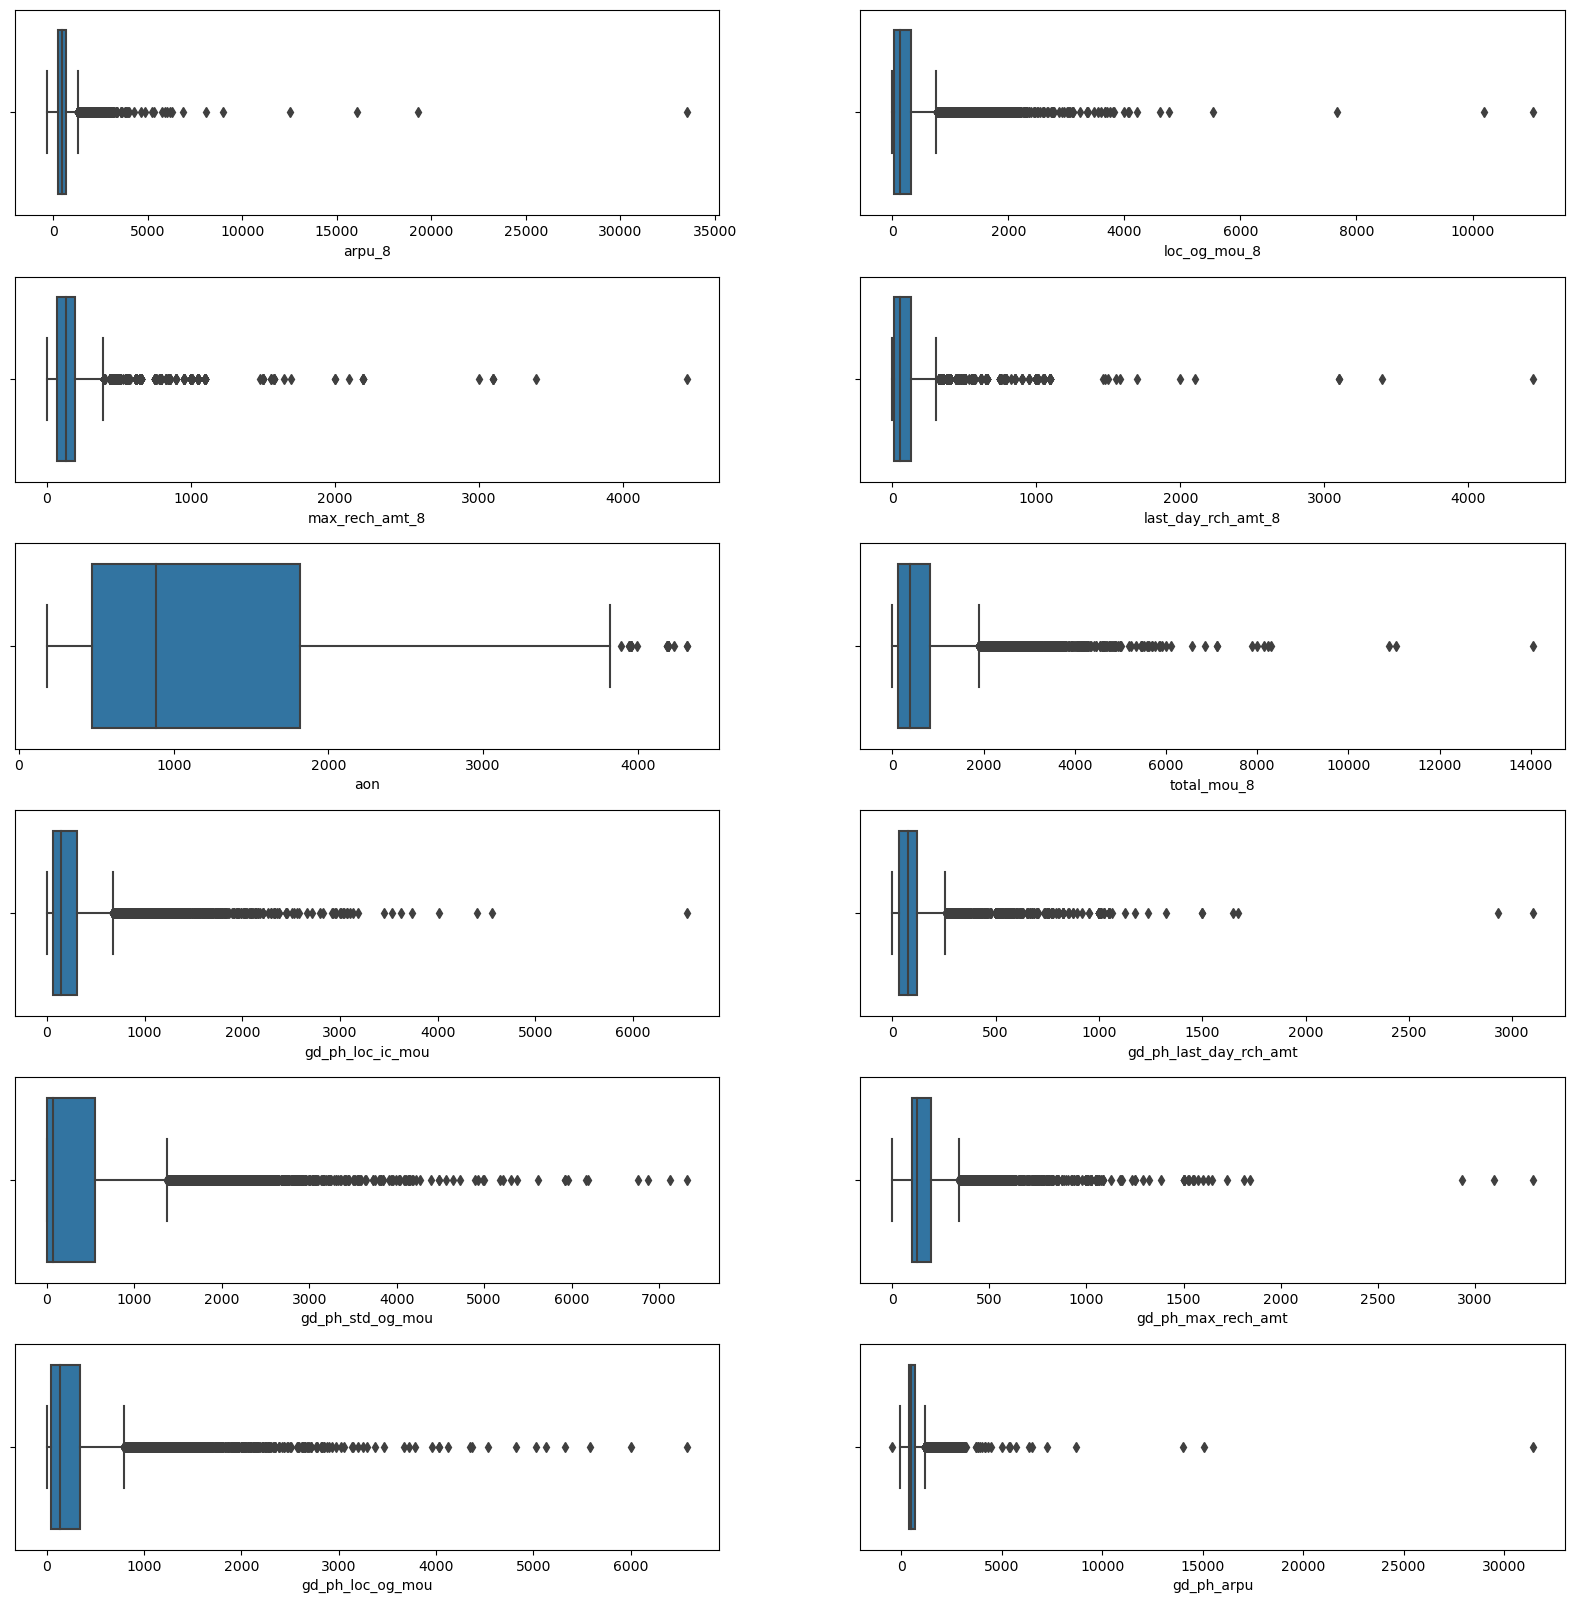

In [31]:
# Going through the output of describe we can filter out the features that needs a second look

# List of features to be analyzed
col_boxplot = ['arpu_8', 'loc_og_mou_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'aon', 'total_mou_8', 
               'gd_ph_loc_ic_mou', 'gd_ph_last_day_rch_amt', 'gd_ph_std_og_mou', 'gd_ph_max_rech_amt', 
              'gd_ph_loc_og_mou', 'gd_ph_arpu']

# Plot boxplots for each variable
fig, axes = plt.subplots(6, 2, figsize=(20, 20))
# sns.boxplot(x=churn_data['arpu_8'], ax=axes[0])
for index, col in enumerate(col_boxplot):
    i, j = divmod(index, 2)
    sns.boxplot(churn_data[col], ax=axes[i, j])
    
plt.subplots_adjust(hspace=0.3) 
plt.show()

> #### Observations
> * From the above plots we can define following upper limits to the sepected variables

> | Feature | Value |
> | --- | --- |
> | arpu_8 | 7000|
> | loc_og_mou_8 | 4000|
> | max_rech_amt_8 | 1000 |
> | last_day_rch_amt_8 | 1000 |
> | aon | 3000 | 
> | total_mou_8 | 4000 | 
> | gd_ph_loc_ic_mou | 3000 |
> | gd_ph_last_day_rch_amt | 1000 |
> | gd_ph_std_og_mou | 4000 | 
> | gd_ph_max_rech_amt | 1500 |
> | gd_ph_loc_og_mou | 3000 |
> | gd_ph_arpu | 7000 |

> * We will make these changes post exploration of other features


In [32]:
# Check churn based on tenure

plt.figure(figsize=(15,7))
sns.scatterplot(y=churn_data['aon'] / 365, x=churn_data.index, hue=churn_data.churn, alpha=0.7)
plt.ylim(0,10)
plt.show()

> #### Observation
> * Though we cannot see a clear pattern here, but we can notice that the mojority of churners had a tenure of less than 4 years

In [33]:
# Lets check how the VBC effects the revenue
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 7))
sns.scatterplot(y='gd_ph_arpu', x='gd_ph_total_mou', data=churn_data, ax=axes[0], hue='churn', alpha=0.7)
sns.scatterplot(y='arpu_8', x='total_mou_8', data=churn_data, ax=axes[1], hue='churn', alpha=0.7)


# Limiting the graph to more general upper bound
plt.ylim(0,10000)
plt.show()

> #### Observation
> * We can clearly see that MOU have dropped significantly for the churners in the action pahse i.e 8th month, thus hitting the revenue generated from them
> * It is also interesting that though the MOU is between 0-2000, the revenue is highest in that region that tells us these users had other services that were boosting the revenue

In [34]:
# Lets check how the total_mou effects the revenue
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 7))
sns.scatterplot(y='gd_ph_arpu', x='gd_ph_vbc_3g', data=churn_data, ax=axes[0], hue='churn', alpha=0.7)
sns.scatterplot(y='arpu_8', x='vbc_3g_8', data=churn_data, ax=axes[1], hue='churn', alpha=0.7)


# Limiting the graph to more general upper bound
plt.ylim(0,10000)
plt.show()

 > #### Observation
 > * We can see that the users who were using very less amount of VBC data and yet were generating high revenue churned
 > * Yet again we see that the revenue is higher towards the lesser consumption side

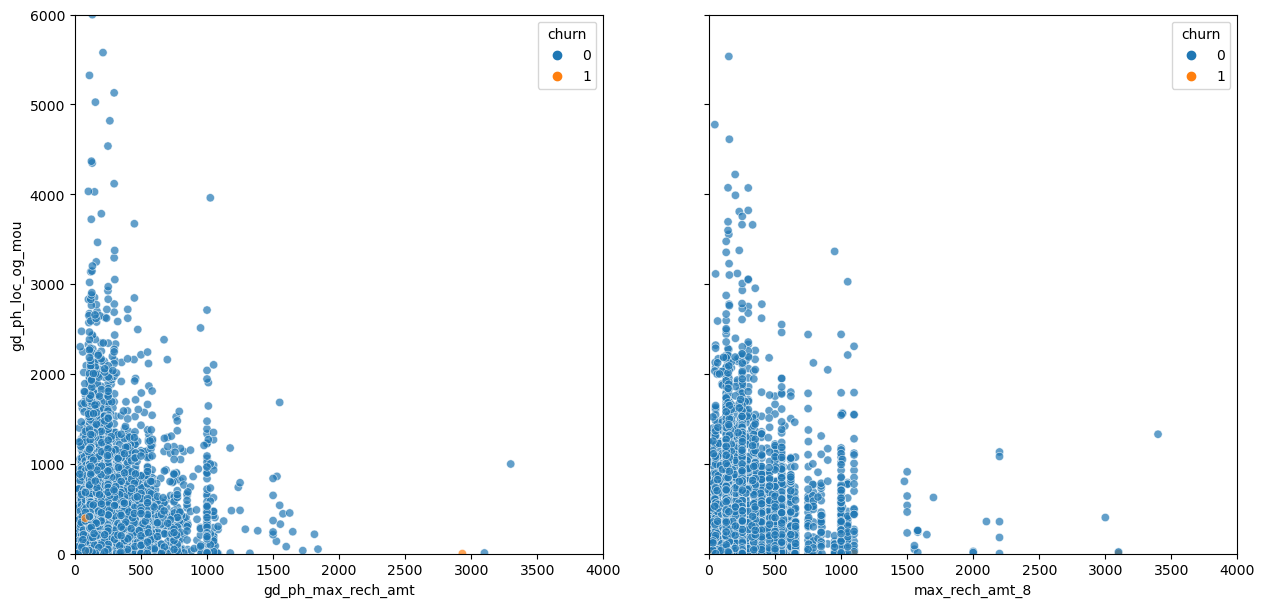

In [35]:
# Lets check the relation between recharge amount and local outgoing calls

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 7))
sns.scatterplot(x='gd_ph_max_rech_amt', y='gd_ph_loc_og_mou', data=churn_data, ax=axes[0],
                hue='churn', alpha=0.7)
sns.scatterplot(x='max_rech_amt_8', y='loc_og_mou_8', data=churn_data, ax=axes[1], hue='churn', alpha=0.7)

# Limiting the graph to more general upper bound
axes[0].set_xlim(0,4000)
axes[1].set_xlim(0,4000)
plt.ylim(0,6000)

plt.show()

> #### Observations
> * Users who were recharging with high amounts were using the service for local uses less as compared to user who did lesser amounts of recharge
> * Intuitevly people whose max recharge amount as well as local out going were very less even in the good phase churned more 

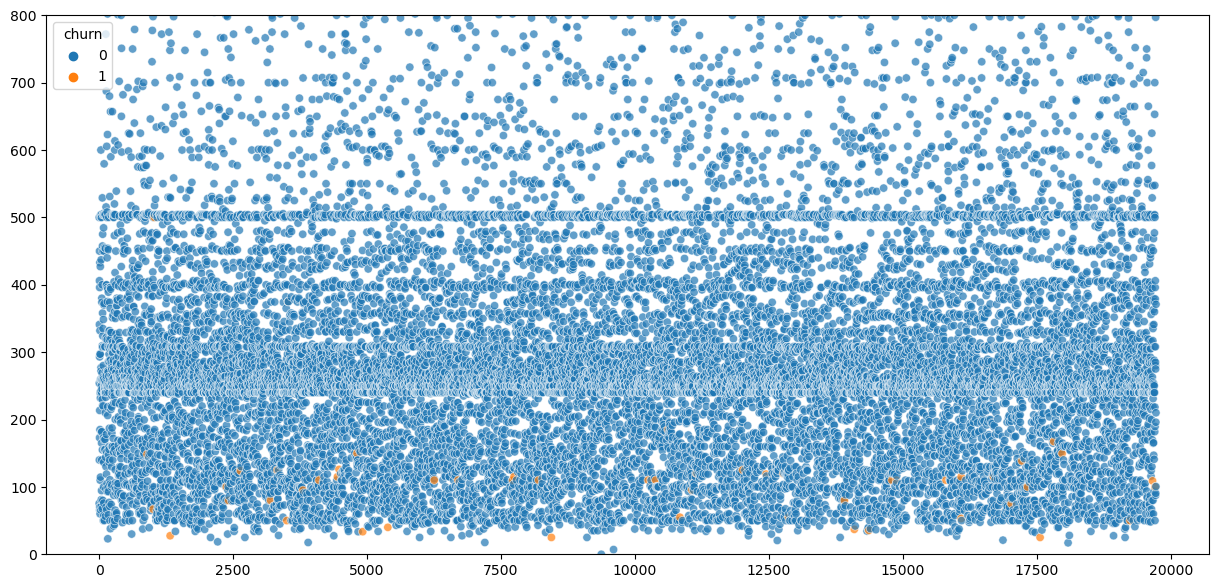

In [36]:
# Check the effect of max recharge amount on churn

plt.figure(figsize=(15,7))
sns.scatterplot(x=churn_data.index, y=churn_data['gd_ph_max_rech_amt'] + churn_data['max_rech_amt_8'],
                hue=churn_data['churn'], alpha=0.7)
plt.ylim(0,800)
plt.show()


> #### Observation
> * We can see that users who had the max recharge amount less tha 200 churned more

In [37]:
# Incoming from the same service provider vs the recharge amount

fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15, 7))
sns.scatterplot(x='gd_ph_max_rech_amt', y='gd_ph_std_ic_t2t_mou', data=churn_data, ax=axes[0],
                hue='churn', alpha=0.7)
sns.scatterplot(x='max_rech_amt_8', y='std_ic_t2t_mou_8', data=churn_data, ax=axes[1], hue='churn', alpha=0.7)

# Limiting the graph to more general upper bound
axes[0].set_xlim(0,2000)
axes[1].set_xlim(0,2000)
plt.ylim(0,2000)

plt.show()

> #### Observation
> * Users who have max recharge amount on the higher end and still have low incoming call mou during the good pahse, churned out more

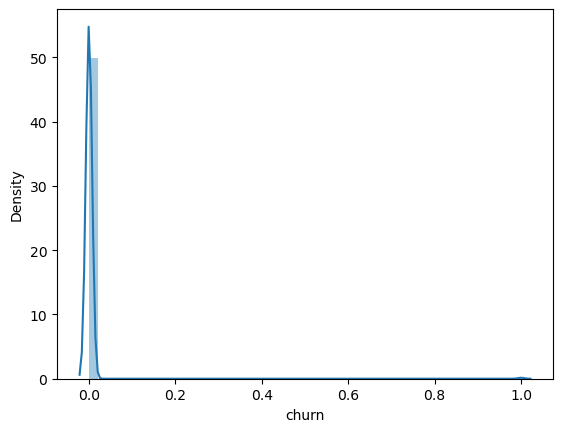

In [38]:
# Distribution of target variable

sns.distplot(churn_data['churn'])
plt.show()

> #### Observation
> * Though the varible is not skwed it is higly imbalanced, the number of non-churners in the dataset is around 94%
> * We will handle this imbalance using SMOTE algorithm

# Data Preperation

In [39]:
# Cap the features with high outliers

col_upr_lmt = [('arpu_8', 7000), ('loc_og_mou_8', 4000), ('max_rech_amt_8', 1000 ), ('last_day_rch_amt_8', 1000 ), 
               ('aon', 3000), ('total_mou_8', 4000), ('gd_ph_loc_ic_mou', 3000), ('gd_ph_last_day_rch_amt', 1000 ), 
               ('gd_ph_std_og_mou', 4000), ('gd_ph_max_rech_amt', 1500), ('gd_ph_loc_og_mou', 3000), ('gd_ph_arpu', 7000)]

for col, value in col_upr_lmt:
    churn_data[col] = churn_data[col].apply(lambda x : x if x < value else value)

churn_data[col_boxplot].head()

arpu_8  loc_og_mou_8  max_rech_amt_8  last_day_rch_amt_8   aon  \
0  101.565         15.76              30                  30   647   
1  338.286        385.26             250                 250   602   
2  479.762        387.79             144                  30   455   
3  240.449        129.73              30                  30  1219   
4  421.300        195.51             164                  61   573   

   total_mou_8  gd_ph_loc_ic_mou  gd_ph_last_day_rch_amt  gd_ph_std_og_mou  \
0        15.76            15.450                    17.5             2.175   
1       391.52           504.770                    75.0             0.000   
2       387.80           419.795                    80.0           101.040   
3       251.89           184.600                    55.0           330.100   
4       195.51           317.035                   155.0             1.265   

   gd_ph_max_rech_amt  gd_ph_loc_og_mou  gd_ph_arpu  
0                45.5            42.425    184.4495  
1               250.0           347.125    478.9215  
2               110.0           886.845   1018.2270  
3               110.0           255.110    362.0215  
4               177.0           154.710    370.7370

In [40]:
y = churn_data['churn']
X = churn_data.drop('churn', axis=1)

## Standardization

In [41]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X[X.columns] = scaler.fit_transform(X[X.columns])

## Handling Class Imbalance

In [42]:
churn_data.churn.value_counts()

0    19667
1       54
Name: churn, dtype: int64

In [43]:
# Use SMOTE to take care of class imbalance
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [44]:
X_res.head()

id    arpu_8  roam_ic_mou_8  roam_og_mou_8  loc_og_t2c_mou_8  \
0 -1.737016 -0.988010      -0.170102      -0.188914         -0.244366   
1 -1.736471 -0.434498      -0.170102      -0.188914         -0.244366   
2 -1.736074 -0.103692      -0.170102      -0.188914         -0.244366   
3 -1.736024 -0.663265      -0.170102      -0.188914         -0.194536   
4 -1.735876 -0.240391      -0.170102      -0.188914         -0.244366   

   loc_og_mou_8  std_og_t2f_mou_8  std_og_mou_8  isd_og_mou_8  spl_og_mou_8  \
0     -0.656517         -0.149802     -0.529835     -0.040512     -0.316490   
1      0.403476          0.428877     -0.519628     -0.040512     -0.316490   
2      0.410734         -0.149802     -0.529835     -0.040512     -0.316039   
3     -0.329569         -0.149802     -0.331255     -0.040512     -0.300234   
4     -0.140865         -0.149802     -0.529835     -0.040512     -0.316490   

   og_others_8  loc_ic_mou_8  std_ic_t2t_mou_8  std_ic_t2f_mou_8  \
0    -0.018762     -0.670664         -0.206437         -0.133573   
1    -0.018762      1.292376         -0.206437         -0.133573   
2    -0.018762     -0.101032         -0.206437         -0.133573   
3    -0.018762     -0.205053         -0.206437         -0.133573   
4    -0.018762      0.380469         -0.200759         -0.133573   

   std_ic_mou_8  spl_ic_mou_8  isd_ic_mou_8  ic_others_8  total_rech_num_8  \
0     -0.344778     -0.261591     -0.159119    -0.090375         -0.263980   
1     -0.344778     -0.261591     -0.159119    -0.090375         -0.697738   
2     -0.344778     -0.261591     -0.159119    -0.063164         -0.047102   
3     -0.180904     -0.261591     -0.159119    -0.090375         -0.047102   
4     -0.341789     -0.261591     -0.159119    -0.090375         -0.697738   

   max_rech_amt_8  last_day_rch_amt_8  vol_2g_mb_8  monthly_2g_8  sachet_2g_8  \
0       -0.916758           -0.518229     0.320986     -0.388147     1.898286   
1        0.615334            1.294026     0.759004      2.038047    -0.427130   
2       -0.122856           -0.518229    -0.342726     -0.388147    -0.427130   
3       -0.916758           -0.518229    -0.342726     -0.388147    -0.039561   
4        0.016425           -0.262866    -0.309956     -0.388147    -0.039561   

   monthly_3g_8  sachet_3g_8       aon  churn_probability    ic_sum    oc_sum  \
0     -0.336448    -0.183431 -0.621837          -0.242112 -0.751569 -0.761549   
1     -0.336448    -0.183431 -0.671495          -0.242112  0.961099  0.933509   
2     -0.336448    -0.183431 -0.833709          -0.242112 -0.254206  0.192530   
3     -0.336448    -0.183431  0.009366          -0.242112 -0.282910 -0.313226   
4      1.289403     0.686563 -0.703496          -0.242112  0.166628  0.114483   

    vol_sum  total_mou_8  gd_ph_isd_og_mou  gd_ph_last_day_rch_amt  \
0 -0.258198    -0.868650         -0.041174               -0.788276   
1 -0.110897    -0.302114         -0.041174               -0.222913   
2 -0.481398    -0.307723         -0.041174               -0.173751   
3 -0.481398    -0.512635         -0.041174               -0.419561   
4  0.933763    -0.597640         -0.041174                0.563678   

   gd_ph_max_rech_amt  gd_ph_arpu  gd_ph_spl_ic_mou  gd_ph_std_ic_mou  \
0           -0.867183   -1.023582         -0.270294         -0.375238   
1            0.602341   -0.229492         -0.270294         -0.371260   
2           -0.403690    1.224830          0.154042          0.424500   
3           -0.403690   -0.544731         -0.270294         -0.311500   
4            0.077767   -0.521228         -0.270294         -0.315634   

   gd_ph_total_mou  gd_ph_std_og_mou  gd_ph_spl_og_mou  gd_ph_loc_ic_mou  \
0        -0.908273         -0.632824          0.098230         -0.771586   
1        -0.473084         -0.636626         -0.351820          0.921046   
2         0.500009         -0.460002         -0.352618          0.627105   
3        -0.111560         -0.059590         -0.353948         -0.186470   
4  

In [45]:
y_res.head()

0    0
1    0
2    0
3    0
4    0
Name: churn, dtype: int64

In [46]:
y_res.value_counts()

0    19667
1    19667
Name: churn, dtype: int64

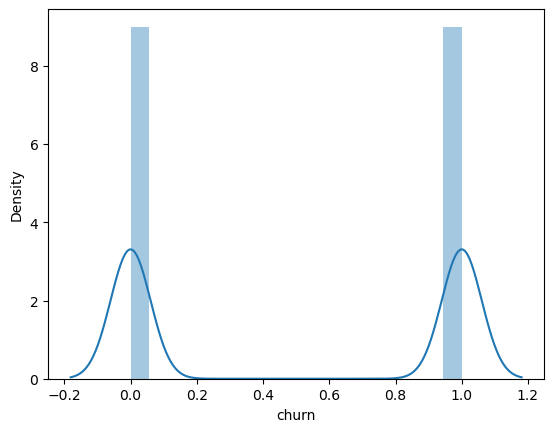

In [47]:
sns.distplot(y_res)
plt.show()

> Now the class is balanced and the target variable is not skwed 

## PCA

In [48]:
X.shape

(19721, 60)

In [49]:
from sklearn.decomposition import PCA

pca = PCA(n_components=25)
X_pca = pca.fit_transform(X_res)
X_pca.shape

(39334, 25)

# Model Building

## 1. Logistic Regression

> For logistic regression we will be using the unaltered X and y so that we can use RFE for feature selection instead of PCA, to find out the strong predictor of churn 

In [50]:
# Split the data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.7, test_size=0.3, random_state=25)

In [51]:
import statsmodels.api as sm

In [52]:
# Initial logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                27533
Model:                            GLM   Df Residuals:                    27472
Model Family:                Binomial   Df Model:                           60
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 31 Jul 2023   Deviance:                       48815.
Time:                        17:22:28   Pearson chi2:                 2.39e+18
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -2.554e+15   5.28e+05  -4.84e+09      0.000   -2.55e+15   -2.55e+15
id                      4.589e+12   4.51e+05   1.02e+07      0.000    4.59e+12    4.59e+12
arpu_8                 -1.246e+14   1.49e+06  -8.38e+07      0.000   -1.25e+14   -1.25e+14
roam_ic_mou_8          -3.653e+17   3.99e+09  -9.16e+07      0.000   -3.65e+17   -3.65e+17
roam_og_mou_8           2.667e+14   6.77e+05   3.94e+08      0.000    2.67e+14    2.67e+14
loc_og_t2c_mou_8       -1.972e+14   6.57e+05     -3e+08      0.000   -1.97e+14   -1.97e+14
loc_og_mou_8            4.502e+14   3.48e+06   1.29e+08      0.000     4.5e+14     4.5e+14
std_og_t2f_mou_8        9.954e+13    8.7e+05   1.14e+08      0.000    9.95e+13    9.95e+13
std_og_mou_8            3.861e+14   3.18e+06   1.22e+08      0.000    3.86e+14    3.86e+14
isd_og_mou_8            1.005e+13   2.55e+06   3.94e+06      0.000    1.01e+13    1.01e+13
spl_og_mou_8           -1.957e+14   7.61e+05  -2.57e+08      0.000   -1.96e+14   -1.96e+14
og_others_8            -1.946e+14   1.54e+06  -1.26e+08      0.000   -1.95e+14   -1.95e+14
loc_ic_mou_8           -4.494e+18   4.92e+10  -9.14e+07      0.000   -4.49e+18   -4.49e+18
std_ic_t2t_mou_8        7.704e+13   1.11e+06   6.92e+07      0.000     7.7e+13     7.7e+13
std_ic_t2f_mou_8         4.26e+13   9.66e+05   4.41e+07      0.000    4.26e+13    4.26e+13
std_ic_mou_8           -1.962e+18   2.15e+10  -9.14e+07      0.000   -1.96e+18   -1.96e+18
spl_ic_mou_8           -1.258e+15   1.17e+07  -1.07e+08      0.000   -1.26e+15   -1.26e+15
isd_ic_mou_8           -7.039e+17    7.7e+09  -9.14e+07      0.000   -7.04e+17   -7.04e+17
ic_others_8            -7.204e+16   7.87e+08  -9.16e+07      0.000    -7.2e+16    -7.2e+16
total_rech_num_8       -1.327e+14   9.12e+05  -1.46e+08      0.000   -1.33e+14   -1.33e+14
max_rech_amt_8          5.371e+12   8.91e+05   6.03e+06      0.000    5.37e+12    5.37e+12
last_day_rch_amt_8      8.766e+13   7.09e+05   1.24e+08      0.000    8.77e+13    8.77e+13
vol_2g_mb_8             -2.44e+14   8.03e+05  -3.04e+08      0.000   -2.44e+14   -2.44e+14
monthly_2g_8           -5.803e+13    7.9e+05  -7.35e+07      0.000    -5.8e+13    -5.8e+13
sachet_2g_8            -1.283e+14   8.39e+05  -1.53e+08      0.000   -1.28e+14   -1.28e+14
monthly_3g_8           -1.567e+14   9.99e+05  -1.57e+08      0.000   -1.57e+14   -1.57e+14
sachet_3g_8            -2.689e+14   8.43e+05  -3.19e+08      0.000   -2.69e+14   -2.69e+14
aon                    -2.671e+12   5.66e+05  -4.72e+06      0.000   -2.67e+12   -2.67e+12
churn_probability       2.152e+13   2.44e+05   8.81e+07      0.000    2.15e+13    2.15e+13
ic_sum                   5.15e+18   5.64e+10   9.13e+07      0.000    5.15e+18    5.15e+18
oc_sum                  3.564e+14    4.4e+06    8.1e+07      0.000    3.56e+14  

### RFE for Feature Selection

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Create LR object
logreg = LogisticRegression(solver='liblinear')

# Run RFE for 25 features
rfe = RFE(logreg, n_features_to_select=25)
rfe = rfe.fit(X_train, y_train)

In [54]:
rfe_col = X.columns[rfe.support_]
rfe_col

Index(['roam_ic_mou_8', 'loc_og_t2c_mou_8', 'std_og_t2f_mou_8', 'std_og_mou_8',
       'spl_og_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_mou_8',
       'spl_ic_mou_8', 'ic_others_8', 'total_rech_num_8', 'vol_2g_mb_8',
       'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'ic_sum',
       'oc_sum', 'vol_sum', 'gd_ph_std_ic_mou', 'gd_ph_std_ic_t2f_mou',
       'gd_ph_std_og_t2f_mou', 'gd_ph_monthly_2g', 'gd_ph_monthly_3g',
       'vbc_3g_8'],
      dtype='object')

In [55]:
# Build model with RFE selected features
X_train_sm = sm.add_constant(X_train[rfe_col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                27533
Model:                            GLM   Df Residuals:                    27507
Model Family:                Binomial   Df Model:                           25
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 31 Jul 2023   Deviance:                       20447.
Time:                        17:22:37   Pearson chi2:                 1.00e+18
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -2.42e+15   5.05e+05  -4.79e+09      0.000   -2.42e+15   -2.42e+15
roam_ic_mou_8        -6.874e+14   6.35e+05  -1.08e+09      0.000   -6.87e+14   -6.87e+14
loc_og_t2c_mou_8     -1.341e+14   6.03e+05  -2.23e+08      0.000   -1.34e+14   -1.34e+14
std_og_t2f_mou_8      1.055e+14   8.64e+05   1.22e+08      0.000    1.06e+14    1.06e+14
std_og_mou_8         -7.711e+14   6.37e+05  -1.21e+09      0.000   -7.71e+14   -7.71e+14
spl_og_mou_8         -2.542e+14   6.64e+05  -3.83e+08      0.000   -2.54e+14   -2.54e+14
loc_ic_mou_8          5.639e+14   3.94e+06   1.43e+08      0.000    5.64e+14    5.64e+14
std_ic_t2t_mou_8     -1.606e+12   9.05e+05  -1.77e+06      0.000   -1.61e+12   -1.61e+12
std_ic_mou_8          6.184e+13   1.93e+06    3.2e+07      0.000    6.18e+13    6.18e+13
spl_ic_mou_8         -2.071e+14   5.78e+05  -3.58e+08      0.000   -2.07e+14   -2.07e+14
ic_others_8           -7.78e+13   9.12e+05  -8.53e+07      0.000   -7.78e+13   -7.78e+13
total_rech_num_8      -4.74e+13   6.84e+05  -6.93e+07      0.000   -4.74e+13   -4.74e+13
vol_2g_mb_8          -4.232e+14   6.61e+05   -6.4e+08      0.000   -4.23e+14   -4.23e+14
monthly_2g_8          -1.06e+14   7.65e+05  -1.39e+08      0.000   -1.06e+14   -1.06e+14
sachet_2g_8          -6.117e+12    6.7e+05  -9.13e+06      0.000   -6.12e+12   -6.12e+12
monthly_3g_8         -1.293e+14   9.34e+05  -1.38e+08      0.000   -1.29e+14   -1.29e+14
sachet_3g_8          -3.513e+14    6.8e+05  -5.17e+08      0.000   -3.51e+14   -3.51e+14
ic_sum               -1.187e+15   4.36e+06  -2.72e+08      0.000   -1.19e+15   -1.19e+15
oc_sum               -8.172e+14    9.8e+05  -8.34e+08      0.000   -8.17e+14   -8.17e+14
vol_sum              -1.885e+14   1.05e+06   -1.8e+08      0.000   -1.88e+14   -1.88e+14
gd_ph_std_ic_mou      2.823e+13   7.75e+05   3.64e+07      0.000    2.82e+13    2.82e+13
gd_ph_std_ic_t2f_mou -7.116e+13   5.73e+05  -1.24e+08      0.000   -7.12e+13   -7.12e+13
gd_ph_std_og_t2f_mou -2.373e+14   9.17e+05  -2.59e+08      0.000   -2.37e+14   -2.37e+14
gd_ph_monthly_2g     -2.162e+13   6.99e+05  -3.09e+07      0.000   -2.16e+13   -2.16e+13
gd_ph_monthly_3g     -5.171e+13   8.01e+05  -6.46e+07      0.000   -5.17e+13   -5.17e+13
vbc_3g_8               -2.9e+14    7.6e+05  -3.81e+08      0.000    -2.9e+14    -2.9e+14
========================================================================================
"""

In [56]:
# Predict on train data

y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

Churn  Churn_Prob  predicted
0      0         0.0          0
1      1         1.0          1
2      1         1.0          1
3      0         0.0          0
4      1         1.0          1

In [57]:
from sklearn import metrics

# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

print()

# The overall accuracy.
print(f'Accuracy : {metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted)}')

[[13578   222]
 [    0 13733]]

Accuracy : 0.9919369483892057


In [58]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_col].values, i) for i in range(X_train[rfe_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
16                ic_sum  97.02
5           loc_ic_mou_8  75.62
7           std_ic_mou_8  11.08
17                oc_sum   4.99
18               vol_sum   4.03
14          monthly_3g_8   2.99
21  gd_ph_std_og_t2f_mou   2.72
2       std_og_t2f_mou_8   2.67
10      total_rech_num_8   2.37
23      gd_ph_monthly_3g   2.18
12          monthly_2g_8   2.07
24              vbc_3g_8   2.04
22      gd_ph_monthly_2g   1.85
19      gd_ph_std_ic_mou   1.82
6       std_ic_t2t_mou_8   1.79
3           std_og_mou_8   1.58
11           vol_2g_mb_8   1.57
13           sachet_2g_8   1.54
4           spl_og_mou_8   1.46
0          roam_ic_mou_8   1.37
1       loc_og_t2c_mou_8   1.36
15           sachet_3g_8   1.26
20  gd_ph_std_ic_t2f_mou   1.17
9            ic_others_8   1.09
8           spl_ic_mou_8   1.08

> Since the VIF for `vol_sum` is very high we will drop it

In [65]:
rfe_col = rfe_col.drop('ic_sum', 1)

In [66]:
# Build new model
X_train_sm = sm.add_constant(X_train[rfe_col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                27533
Model:                            GLM   Df Residuals:                    27509
Model Family:                Binomial   Df Model:                           23
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 31 Jul 2023   Deviance:                       30210.
Time:                        17:23:17   Pearson chi2:                 1.48e+18
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -2.457e+15   5.05e+05  -4.87e+09      0.000   -2.46e+15   -2.46e+15
roam_ic_mou_8        -8.906e+14   5.49e+05  -1.62e+09      0.000   -8.91e+14   -8.91e+14
loc_og_t2c_mou_8     -2.486e+14   6.03e+05  -4.12e+08      0.000   -2.49e+14   -2.49e+14
std_og_t2f_mou_8      7.899e+13   8.64e+05   9.14e+07      0.000     7.9e+13     7.9e+13
std_og_mou_8           -9.4e+14   6.37e+05  -1.47e+09      0.000    -9.4e+14    -9.4e+14
spl_og_mou_8         -2.513e+14   6.64e+05  -3.79e+08      0.000   -2.51e+14   -2.51e+14
loc_ic_mou_8         -4.227e+14   9.85e+05  -4.29e+08      0.000   -4.23e+14   -4.23e+14
std_ic_t2t_mou_8     -1.199e+12   9.05e+05  -1.32e+06      0.000    -1.2e+12    -1.2e+12
std_ic_mou_8         -6.098e+14   9.78e+05  -6.23e+08      0.000    -6.1e+14    -6.1e+14
spl_ic_mou_8         -2.277e+14   5.78e+05  -3.94e+08      0.000   -2.28e+14   -2.28e+14
ic_others_8          -1.652e+14   8.84e+05  -1.87e+08      0.000   -1.65e+14   -1.65e+14
total_rech_num_8     -3.718e+13   6.83e+05  -5.44e+07      0.000   -3.72e+13   -3.72e+13
vol_2g_mb_8           -3.67e+14   6.18e+05  -5.94e+08      0.000   -3.67e+14   -3.67e+14
monthly_2g_8         -5.302e+13   7.48e+05  -7.09e+07      0.000    -5.3e+13    -5.3e+13
sachet_2g_8          -7.995e+13   6.67e+05   -1.2e+08      0.000      -8e+13      -8e+13
monthly_3g_8         -1.838e+14   8.18e+05  -2.25e+08      0.000   -1.84e+14   -1.84e+14
sachet_3g_8          -4.092e+14   6.46e+05  -6.33e+08      0.000   -4.09e+14   -4.09e+14
oc_sum               -7.329e+14    9.8e+05  -7.48e+08      0.000   -7.33e+14   -7.33e+14
gd_ph_std_ic_mou      1.142e+14   7.75e+05   1.47e+08      0.000    1.14e+14    1.14e+14
gd_ph_std_ic_t2f_mou -1.262e+14   5.73e+05   -2.2e+08      0.000   -1.26e+14   -1.26e+14
gd_ph_std_og_t2f_mou -3.298e+14   9.17e+05   -3.6e+08      0.000    -3.3e+14    -3.3e+14
gd_ph_monthly_2g     -1.217e+14   6.98e+05  -1.74e+08      0.000   -1.22e+14   -1.22e+14
gd_ph_monthly_3g     -1.345e+14   7.98e+05  -1.69e+08      0.000   -1.35e+14   -1.35e+14
vbc_3g_8             -3.998e+14   6.74e+05  -5.93e+08      0.000      -4e+14      -4e+14
========================================================================================
"""

In [67]:
# Predict on train data

y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

Churn  Churn_Prob  predicted
0      0         0.0          0
1      1         1.0          1
2      1         1.0          1
3      0         0.0          0
4      1         1.0          1

In [68]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

print()

# The overall accuracy.
print(f'Accuracy : {metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted)}')

[[13472   328]
 [    0 13733]]

Accuracy : 0.9880870228453129


In [69]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_col].values, i) for i in range(X_train[rfe_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
16                oc_sum  4.99
5           loc_ic_mou_8  4.72
7           std_ic_mou_8  2.83
19  gd_ph_std_og_t2f_mou  2.72
2       std_og_t2f_mou_8  2.67
10      total_rech_num_8  2.36
14          monthly_3g_8  2.29
21      gd_ph_monthly_3g  2.16
12          monthly_2g_8  1.98
20      gd_ph_monthly_2g  1.85
17      gd_ph_std_ic_mou  1.82
6       std_ic_t2t_mou_8  1.79
22              vbc_3g_8  1.60
3           std_og_mou_8  1.58
13           sachet_2g_8  1.52
4           spl_og_mou_8  1.46
11           vol_2g_mb_8  1.37
1       loc_og_t2c_mou_8  1.36
18  gd_ph_std_ic_t2f_mou  1.17
15           sachet_3g_8  1.14
8           spl_ic_mou_8  1.08
9            ic_others_8  1.03
0          roam_ic_mou_8  1.02

In [70]:
# Drop 'gd_ph_total_mou'
rfe_col = rfe_col.drop('oc_sum', 1)

In [71]:
# Build new model
X_train_sm = sm.add_constant(X_train[rfe_col])
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                27533
Model:                            GLM   Df Residuals:                    27510
Model Family:                Binomial   Df Model:                           22
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 31 Jul 2023   Deviance:                       16671.
Time:                        17:23:47   Pearson chi2:                 8.15e+17
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -2.515e+15   5.02e+05  -5.01e+09      0.000   -2.51e+15   -2.51e+15
roam_ic_mou_8        -7.834e+14   5.49e+05  -1.43e+09      0.000   -7.83e+14   -7.83e+14
loc_og_t2c_mou_8     -1.904e+14   6.03e+05  -3.16e+08      0.000    -1.9e+14    -1.9e+14
std_og_t2f_mou_8      7.643e+13   8.64e+05   8.85e+07      0.000    7.64e+13    7.64e+13
std_og_mou_8         -5.064e+14   6.37e+05  -7.96e+08      0.000   -5.06e+14   -5.06e+14
spl_og_mou_8         -3.316e+14   6.64e+05     -5e+08      0.000   -3.32e+14   -3.32e+14
loc_ic_mou_8         -1.361e+15   5.48e+05  -2.49e+09      0.000   -1.36e+15   -1.36e+15
std_ic_t2t_mou_8      2.354e+13   9.05e+05    2.6e+07      0.000    2.35e+13    2.35e+13
std_ic_mou_8           -3.6e+14   9.78e+05  -3.68e+08      0.000    -3.6e+14    -3.6e+14
spl_ic_mou_8         -1.244e+14   5.78e+05  -2.15e+08      0.000   -1.24e+14   -1.24e+14
ic_others_8           -1.98e+14   8.83e+05  -2.24e+08      0.000   -1.98e+14   -1.98e+14
total_rech_num_8     -3.854e+13    6.7e+05  -5.75e+07      0.000   -3.85e+13   -3.85e+13
vol_2g_mb_8          -6.133e+14   6.18e+05  -9.92e+08      0.000   -6.13e+14   -6.13e+14
monthly_2g_8         -3.367e+14   7.48e+05   -4.5e+08      0.000   -3.37e+14   -3.37e+14
sachet_2g_8          -2.918e+13   6.65e+05  -4.39e+07      0.000   -2.92e+13   -2.92e+13
monthly_3g_8         -2.684e+14   8.18e+05  -3.28e+08      0.000   -2.68e+14   -2.68e+14
sachet_3g_8          -3.694e+14   6.45e+05  -5.72e+08      0.000   -3.69e+14   -3.69e+14
gd_ph_std_ic_mou      1.082e+14   7.74e+05    1.4e+08      0.000    1.08e+14    1.08e+14
gd_ph_std_ic_t2f_mou -2.662e+13   5.73e+05  -4.64e+07      0.000   -2.66e+13   -2.66e+13
gd_ph_std_og_t2f_mou  -2.59e+14   9.17e+05  -2.82e+08      0.000   -2.59e+14   -2.59e+14
gd_ph_monthly_2g       2.42e+13   6.98e+05   3.47e+07      0.000    2.42e+13    2.42e+13
gd_ph_monthly_3g     -1.386e+13   7.98e+05  -1.74e+07      0.000   -1.39e+13   -1.39e+13
vbc_3g_8             -5.921e+14   6.74e+05  -8.78e+08      0.000   -5.92e+14   -5.92e+14
========================================================================================
"""

In [72]:
# Predict on train data

y_train_pred = res.predict(X_train_sm).values.reshape(-1)
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

Churn  Churn_Prob  predicted
0      0         0.0          0
1      1         1.0          1
2      1         1.0          1
3      0         0.0          0
4      1         1.0          1

In [73]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

print()

# The overall accuracy.
print(f'Accuracy : {metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted)}')

[[13666   134]
 [   47 13686]]

Accuracy : 0.9934260705335416


In [74]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_col].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_col].values, i) for i in range(X_train[rfe_col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
7           std_ic_mou_8  2.82
18  gd_ph_std_og_t2f_mou  2.72
2       std_og_t2f_mou_8  2.67
14          monthly_3g_8  2.29
10      total_rech_num_8  2.26
20      gd_ph_monthly_3g  2.16
12          monthly_2g_8  1.98
19      gd_ph_monthly_2g  1.84
16      gd_ph_std_ic_mou  1.82
6       std_ic_t2t_mou_8  1.79
21              vbc_3g_8  1.60
3           std_og_mou_8  1.58
13           sachet_2g_8  1.52
4           spl_og_mou_8  1.46
5           loc_ic_mou_8  1.40
11           vol_2g_mb_8  1.37
1       loc_og_t2c_mou_8  1.36
17  gd_ph_std_ic_t2f_mou  1.17
15           sachet_3g_8  1.14
8           spl_ic_mou_8  1.08
9            ic_others_8  1.02
0          roam_ic_mou_8  1.02

> The VIF values looks good now, we can proceed further

In [75]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [76]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.9965775868346319

In [77]:
# Let us calculate specificity
TN / float(TN+FP)

0.9902898550724638

In [78]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.009710144927536232


In [79]:
# positive predictive value 
print (TP / float(TP+FP))

0.9903039073806078


In [80]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9965725953474804


### Plotting ROC

In [81]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False)
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

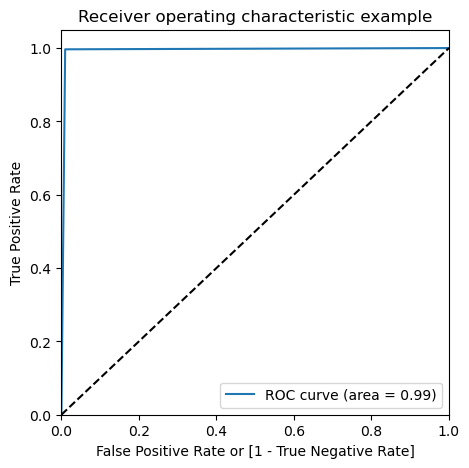

In [82]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

### Optimal cutoff point

In [83]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Churn  Churn_Prob  predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  \
0      0         0.0          0    0    0    0    0    0    0    0    0    0   
1      1         1.0          1    1    1    1    1    1    1    1    1    1   
2      1         1.0          1    1    1    1    1    1    1    1    1    1   
3      0         0.0          0    0    0    0    0    0    0    0    0    0   
4      1         1.0          1    1    1    1    1    1    1    1    1    1   

   0.9  
0    0  
1    1  
2    1  
3    0  
4    1

In [84]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5, 0.5, 0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi    speci
0.0   0.0  0.993426  0.996578  0.99029
0.1   0.1  0.993426  0.996578  0.99029
0.2   0.2  0.993426  0.996578  0.99029
0.3   0.3  0.993426  0.996578  0.99029
0.4   0.4  0.993426  0.996578  0.99029
0.5   0.5  0.993426  0.996578  0.99029
0.6   0.6  0.993426  0.996578  0.99029
0.7   0.7  0.993426  0.996578  0.99029
0.8   0.8  0.993426  0.996578  0.99029
0.9   0.9  0.993426  0.996578  0.99029


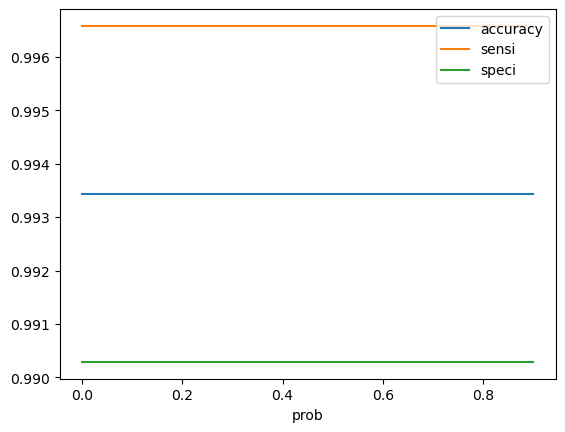

In [85]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

> The point 0.5 is optimal for our model, so we will keep that

In [86]:
X_test = X_test[rfe_col]
X_test_sm = sm.add_constant(X_test)

# Predict on test data

y_test_pred = res.predict(X_test_sm)
y_test_pred_final = pd.DataFrame({'Churn':y_test.values, 'Churn_Prob':y_test_pred})
y_test_pred_final['predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_test_pred_final.head()

Churn  Churn_Prob  predicted
7269       0         0.0          0
31683      1         1.0          1
6398       0         0.0          0
29555      1         1.0          1
26706      1         1.0          1

In [87]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_test_pred_final.Churn, y_test_pred_final.predicted )
print(confusion)

print()

# The overall accuracy.
print(f'Accuracy : {metrics.accuracy_score(y_test_pred_final.Churn, y_test_pred_final.predicted)}')

[[5817   50]
 [  23 5911]]

Accuracy : 0.9938140835522413


In [ ]:
# Top 10 predictors

abs(res.params).sort_values(ascending=False)[0:11]

> * So using Logistic regression we are geting an accuracy of 78.5% on train data and 78.8% on test data
> * We can clearly see most of the critical features are form the `action` phase, which is inline with the bussiness understanding that `action` phase needs more attention

## 2. Decission Tree

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_res, train_size=0.7, random_state=25)

In [89]:
from sklearn.tree import DecisionTreeClassifier

# Initial classifier
intial_dt = DecisionTreeClassifier(random_state=42, max_depth=10)
intial_dt.fit(X_train, y_train)

# Train Accuracy
y_train_pred = intial_dt.predict(X_train)
print(f'Train accuracy : {metrics.accuracy_score(y_train, y_train_pred)}')

y_test_pred = intial_dt.predict(X_test)

# Print the report on test data
print(metrics.classification_report(y_test, y_test_pred))

Train accuracy : 0.9841644571968183
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      5867
           1       0.96      1.00      0.98      5934

    accuracy                           0.98     11801
   macro avg       0.98      0.98      0.98     11801
weighted avg       0.98      0.98      0.98     11801



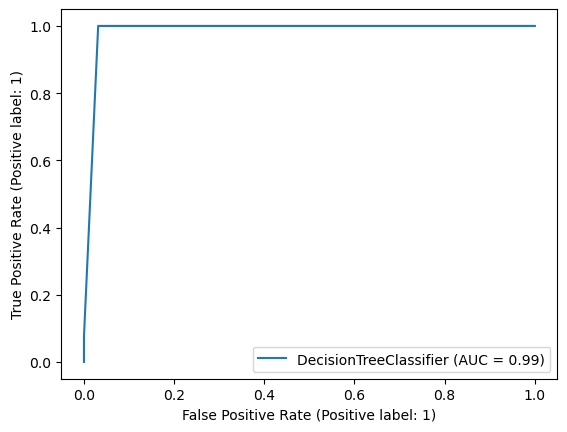

In [90]:
# Plot ROC curve
from sklearn.metrics import plot_roc_curve
plot_roc_curve(intial_dt, X_train, y_train, drop_intermediate=False)
plt.show()

### Hyperparameter tuning

In [91]:
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(random_state=42)

# Define parameters
params = {
    "max_depth": [2, 3, 5, 10, 20, 30, 40, 50, 100],
    "min_samples_leaf": [5, 10, 20, 50, 100, 250, 500, 800, 1000],
    "min_samples_leaf" : [1, 5, 10, 25, 50, 100]
}

grid_search = GridSearchCV(estimator=dt,
                           param_grid=params,
                           cv=4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

# Perform gridsearch
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 54 candidates, totalling 216 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20, 30, 40, 50, 100],
                         'min_samples_leaf': [1, 5, 10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [92]:
grid_search.best_score_

0.99164644861406

In [93]:
# Best estimator
dt_best = grid_search.best_estimator_
dt_best

DecisionTreeClassifier(max_depth=50, random_state=42)

In [94]:
y_train_pred = dt_best.predict(X_train)
y_test_pred = dt_best.predict(X_test)

# Print the report
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5867
           1       0.99      1.00      0.99      5934

    accuracy                           0.99     11801
   macro avg       0.99      0.99      0.99     11801
weighted avg       0.99      0.99      0.99     11801



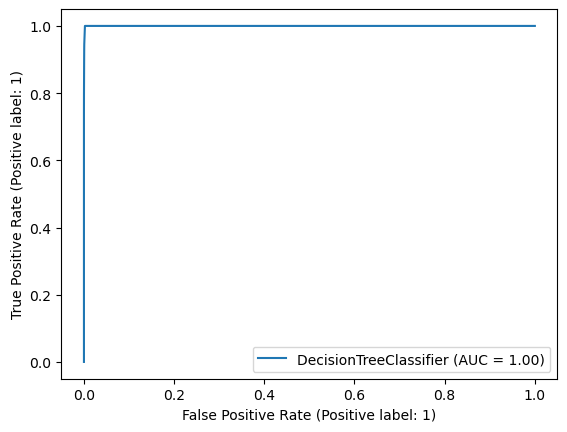

In [95]:
# ROC
plot_roc_curve(dt_best, X_train, y_train)
plt.show()

> We are getting an accuracy of 99% on test data, with decission tree

## 3. Random Forest

In [96]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=15, max_depth=10, max_features=5, random_state=25, oob_score=True)
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)

# Train Accuracy
y_train_pred = intial_dt.predict(X_train)
print(f'Train accuracy : {metrics.accuracy_score(y_train, y_train_pred)}')

y_test_pred = rf.predict(X_test)

# Print the report
print(metrics.classification_report(y_test, y_test_pred))

# Plotting ROC
plot_roc_curve(rf, X_train, y_train)
plt.show()

Train accuracy : 0.9841644571968183
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      5867
           1       0.98      1.00      0.99      5934

    accuracy                           0.99     11801
   macro avg       0.99      0.99      0.99     11801
weighted avg       0.99      0.99      0.99     11801



### Hyperparameter tuning

In [97]:
rf = RandomForestClassifier(random_state=25, n_jobs=-1)

# Define parameters
params = {
    'max_depth': [2, 3, 5, 10, 20, 30],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'n_estimators': [10, 25, 50, 100]
}

grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 120 candidates, totalling 480 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=25),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20, 30],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='accuracy', verbose=1)

In [98]:
grid_search.best_score_

0.9930265288258308

In [99]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=30, min_samples_leaf=5, n_estimators=50,
                       n_jobs=-1, random_state=25)

In [100]:
y_train_pred = rf_best.predict(X_train)
y_test_pred = rf_best.predict(X_test)

# Print the report
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5867
           1       0.99      1.00      0.99      5934

    accuracy                           0.99     11801
   macro avg       0.99      0.99      0.99     11801
weighted avg       0.99      0.99      0.99     11801



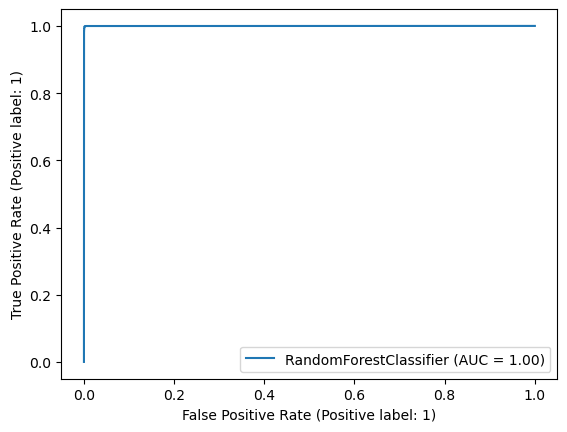

In [101]:
plot_roc_curve(rf_best, X_train, y_train)
plt.show()

> We are getting an accuracy of 95% on test data, with Random forest

## 4. Adaboost

In [102]:
from sklearn.ensemble import AdaBoostClassifier

In [103]:
# Create a shallow tree as weak learner
shallow_tree = DecisionTreeClassifier(max_depth=2, random_state = 100)

# Fit the shallow decision tree 
shallow_tree.fit(X_train, y_train)

# Test error
y_pred = shallow_tree.predict(X_test)
score = metrics.accuracy_score(y_test, y_pred)
score

0.9432251504109821

In [104]:
# Adaboost with shallow tree as base estimator

# Define the number of trees to be used or estimators
estimators = list(range(1, 150, 10))

# Loop through the estimators
adaboost_scores = []
for num_est in estimators:
    adaboost = AdaBoostClassifier(base_estimator=shallow_tree, n_estimators = num_est, random_state=25)
    
    adaboost.fit(X_train, y_train)
    y_pred = adaboost.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred)
    adaboost_scores.append(score)

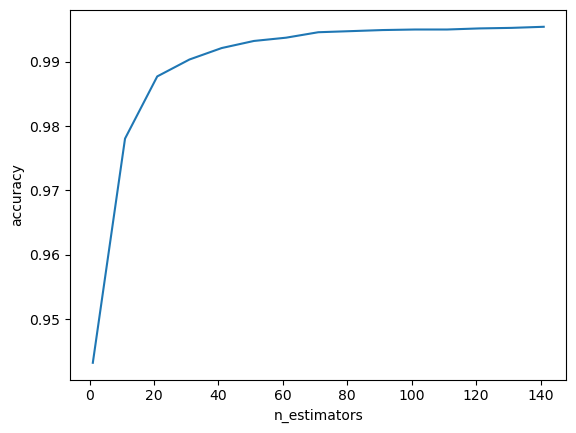

In [105]:
# Plot the scores corrosponding to number of estimators to find the best possible number of estimator
plt.plot(estimators, adaboost_scores)
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.show()

In [106]:
adaboost_best = AdaBoostClassifier(base_estimator=shallow_tree, n_estimators = 200, random_state=25)
adaboost_best.fit(X_train, y_train)
y_pred = adaboost_best.predict(X_test)

print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5867
           1       0.99      1.00      0.99      5934

    accuracy                           0.99     11801
   macro avg       0.99      0.99      0.99     11801
weighted avg       0.99      0.99      0.99     11801



# Conclusions

* Given our bussines probelm, to retain their customers, we need higher recall. As giving an offer to an user not going to churn will cost less as compared to loosing a customer and bring new customer, we need to have high rate of correctly identifying the true positives, hence recall.

* When we compare the models trained we can see the tuned random forest and ada boost are performing the best, which is highest accuracy along with highest recall i.e. 95% and 97% respectively. So, we will go with random forest instead of adaboost as that is comparetively simpler model.


In [107]:
final_model = RandomForestClassifier(max_depth=30, min_samples_leaf=5, n_jobs=-1,
                       random_state=25)

In [108]:
y_train_pred = rf_best.predict(X_train)
y_test_pred = rf_best.predict(X_test)



# Print the report
print("Report on train data")
print(metrics.classification_report(y_train, y_train_pred))

print("Report on test data")
print(metrics.classification_report(y_test, y_test_pred))

Report on train data
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     13800
           1       0.99      1.00      1.00     13733

    accuracy                           1.00     27533
   macro avg       1.00      1.00      1.00     27533
weighted avg       1.00      1.00      1.00     27533

Report on test data
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      5867
           1       0.99      1.00      0.99      5934

    accuracy                           0.99     11801
   macro avg       0.99      0.99      0.99     11801
weighted avg       0.99      0.99      0.99     11801



## Strategies to Manage Customer Churn

The top 10 predictors are :

| Features |
| ---------- |
| std_ic_mou_8 |
| gd_ph_std_og_t2f_mou |
| std_og_t2f_mou_8 |
| monthly_3g_8 |
| total_rech_num_8 |
| monthly_2g_8 |
| gd_ph_monthly_2g |
| gd_ph_std_ic_mou |
| vbc_3g_8 |
| std_og_mou_8 |


* We can see most of the top predictors are from the action phase, as the drop in engagement is prominent in that phase

Some of the factors we noticed while performing EDa which can be clubed with these inshigts are:
1. Users whose maximum recharge amount is less than 200 even in the good pahse, should have a tag and re-evaluated time to time as they are more likely to churn
2. Users that have been with the network less than 4 years, should be monitored time to time, as from data we can see that users who have been associated with the network for less than 4 years tend to churn more
3. MOU is one of the major factors, but data especially VBC if the user is not using a data pack if another factor to look out